In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from astropy.table import Table
from scipy import stats
import warnings
from TESStools import *
from tqdm.notebook import tqdm

# Let's put together our sample

In [20]:
massive_observed = pd.read_csv('../data/massive_observed.csv')

#here's the YSGs
ysgs = massive_observed[massive_observed['SpT']=='YSG'].reset_index(drop=True)

#here's the RSGs
rsgs = massive_observed[massive_observed['SpT']=='RSG'].reset_index(drop=True)

#Let's get the TIC x-match for a catalog of these stars
ysg_tics = glob('../../Proposals/TESS_C3/data/*YSG_TIC*')
dfs = []
for y in ysg_tics:
    df = pd.read_csv(y,skiprows=4)
    df['SpecSource'] = ['N' for i in range(len(df))]
    dfs.append(df)
ysg_tic = pd.concat(dfs).reset_index(drop=True)[['MatchID','teff','lum','SpecSource','w1mag','w2mag','w3mag','w4mag']]
ysg_tic = ysg_tic[ysg_tic['lum'] > 4.0].reset_index(drop=True)

rsg_tics = glob('../../Proposals/TESS_C3/data/*RSG_TIC*')
rsg_tics.append('../../Proposals/TESS_C3/data/galactic_all_TIC.csv')
dfs = []
for r in rsg_tics:
    if 'MC' in r: #First we use Teff and L from Kathryn's paper
        df = pd.read_csv(r,skiprows=4)
        df['teff'] = np.log10(df['Teff'])
        df['lum'] = df['LogL']
        df['SpecSource'] = ['N' for i in range(len(df))]
        dfs.append(df)
    elif 'Levesque' in r: #Then we get it from Emily's paper
        df = pd.read_csv(r,skiprows=4)
        df['SpecSource'] = ['L' for i in range(len(df))]
        dfs.append(df)
    else: #Then we estimate it from Gaia
        df = pd.read_csv(r,skiprows=4)
        keep = [('K' in S) or ('M' in S) for S in df['SpecType'].values]
        df = df[keep].reset_index(drop=True)
        df['teff'] = np.log10(df['Teff']) #rough T and L from R in TIC. It's not great.
        df['lum'] = 2.0*np.log10(df['rad']) + 4.0*np.log10(df['Teff']/5777.0) #assuming T_sun = 5777
        df['SpecSource'] = ['T' for i in range(len(df))]
        dfs.append(df)
rsg_tic = pd.concat(dfs).reset_index(drop=True)[['MatchID','teff','lum','SpecSource','RA','Dec','w1mag','w2mag','w3mag','w4mag']]
rsg_tic = rsg_tic[rsg_tic['lum'] > 4.0].reset_index(drop=True)
#Now cross match and concatenate
ysg_spec = pd.merge(ysgs,ysg_tic,left_on='TIC ID',right_on='MatchID').sort_values('teff').reset_index(drop=True)
print(len(ysg_spec))
rsg_spec = pd.merge(rsgs,rsg_tic,suffixes=('','_y'),left_on='TIC ID',right_on='MatchID').sort_values('teff').reset_index(drop=True)
rsg_spec.loc[rsg_spec['CommonName']=='V* V772 Cen',['teff','lum','SpecSource']] = [3.56,4.63,'I']
#drop duplicate RSGs
rsg_spec = rsg_spec.sort_values('SpecSource').drop_duplicates(subset='MatchID')
#Estimated from Spectrum published in Ivanov et al. 2019
print(len(rsg_spec))

cool_sgs = pd.concat([ysg_spec,rsg_spec]).sort_values('teff').reset_index(drop=True)
cool_sgs

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



28
48


/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



CommonName  ContRatio        Dec      Dec_y MKType    MatchID  \
0   V* V1092 Cen        NaN -61.319446 -61.319444     Ma  290678703   
1      V* HS Cas        NaN  63.586529  63.586444   M4Ia   52782147   
2      HD 143183        NaN -54.143224 -54.143194   M2II  423407817   
3    BD+35  4077        NaN  35.621266  35.621278     M2  136034302   
4      V* AD Per        NaN  56.993123  56.993139     K5  348314378   
..           ...        ...        ...        ...    ...        ...   
71     HD 269786        NaN -69.750564        NaN      B  277022505   
72     HD 269101        NaN -68.769410        NaN  B3Iab   40343782   
73   SK -69   68        NaN -69.117163        NaN   B1II   40515514   
74     HD 268798        NaN -68.420082        NaN     B:   30317301   
75     HD 269769        NaN -69.781048        NaN  B0.5I  276936458   

            RA        RA_y     SimbadOType   SimbadSpT  ...     Tmag  \
0   174.109242  174.109250          RedSG*  M2.5Iab-Ib  ...   5.2902   
1    17.083001   17.083042          RedSG*        M4Ia  ...   5.8870   
2   240.400927  240.400958            Star    M1/2+B/F  ...   4.2452   
3   305.308620  305.308625  Candidate_RSG*      M3Iab:  ...   5.6839   
4    35.120845   35.120875          RedSG*       M3Iab  ...   5.3572   
..         ...         ...             ...         ...  ...      ...   
71   83.765010         NaN            Star         B1I  ...   9.6554   
72   77.438306         NaN         BlueSG*       B3Iab  ...  10.5774   
73   77.495018         NaN            Star        B1II  ...  11.5257   
74   74.283565         NaN         BlueSG*        B2Ia  ...  10.1029   
75   83.628569         NaN            Star       B0.5I  ...  10.6998   

        dist       lum     pmDec      pmRA      teff   w1mag   w2mag   w3mag  \
0   0.014385  4.448384  0.743760 -6.708710  3.533899  -0.064   0.535   1.391   
1   0.311666  4.559673 -0.356649 -2.450310  3.534787  -0.005   0.456   0.484   
2   0.125067  5.221911 -3.619550 -2.301300  3.536937  -1.944  -2.109  -1.939   
3   0.044789  4.749189 -4.498820 -2.845520  3.537693  -1.054  -0.279  -0.007   
4   0.082087  4.586749 -1.423260 -0.065776  3.543323  -0.133   0.429   0.609   
..       ...       ...       ...       ...       ...     ...     ...     ...   
71  0.034086  5.116000  0.508153  1.871520  4.000000  10.901  10.894  11.488   
72  0.076791  4.799000 -0.125497  1.760170  4.027000  11.623  11.201   7.533   
73  0.026671  4.611000  0.180033  2.310890  4.029000  11.806  11.884  10.974   
74  0.030703  5.071000 -0.074064  1.942290  4.033000  11.225  11.268   9.651   
75  0.074228  4.714000  0.525752  1.782630  4.037000     NaN     NaN     NaN   

    w4mag  
0   0.593  
1  -0.555  
2  -3.462  
3  -1.092  
4  -0.308  
..    ...  
71  8.870  
72  4.305  
73  9.724  
74  4.244  
75    NaN  

[76 rows x 23 columns]

In [21]:
cool_sgs.columns

Index(['CommonName', 'ContRatio', 'Dec', 'Dec_y', 'MKType', 'MatchID', 'RA',
       'RA_y', 'SimbadOType', 'SimbadSpT', 'SpT', 'SpecSource', 'TIC ID',
       'Tmag', 'dist', 'lum', 'pmDec', 'pmRA', 'teff', 'w1mag', 'w2mag',
       'w3mag', 'w4mag'],
      dtype='object')

In [22]:
'SV* Vlskdjf'[0:2]

'SV'

In [24]:
header = r"""\begin{deluxetable*}{lccccccccccc}
\tabletypesize{\scriptsize}
\tablecaption{Cool supergiants observed by \tess. The source of the $T_{eff}$ and $\log L$ measurements is indicated, where N corresponds to \citet{neugent12_ysg}, L to \citet{levesque05,levesque06,levesque07,levesque09}, I to \citet{ivanov19}, and T to \citet{stassun18}\label{tab:sample}}
\tablehead{\colhead{Common Name} & \colhead{TIC Number} & \colhead{R.A.} & \colhead{Dec} & \colhead{$\mu_\alpha$} & \colhead{$\mu_\delta$} &  \colhead{$T$} & \colhead{$\log T_{{eff}}$} & \colhead{$\log L_{{eff}}$} & \colhead{Source}  & \colhead{RSG/YSG?} & \colhead{Var. Type}\\
\colhead{} & \colhead{} & \colhead{[deg]} & \colhead{[deg]} & \colhead{[mas/yr]} & \colhead{[mas/yr]} & \colhead{[mag]} & \colhead{[K]} & \colhead{$L_\odot$} & \colhead{} & \colhead{} & \colhead{} } 
\startdata
"""
fyps = cool_sgs[(cool_sgs['teff'] >= 3.69)&(cool_sgs['teff'] <= 3.8)&(cool_sgs['lum']>= 5.1)&(cool_sgs['lum']<=5.5)]
aceps = cool_sgs[(cool_sgs['teff'] >= 4.0)&(cool_sgs['lum'] <= 5.1)]
for i,row in cool_sgs.iterrows():
    name = row['CommonName'].lstrip('V*')
    if name[0:2] == 'SV':
        name = name.lstrip('SV*')
    tic = row['MatchID']
    ra = f"{row['RA']:.8f}"
    dec = f"{row['Dec']:.8f}"
    pmra = f"{row['pmRA']:.3f}"
    pmdec = f"{row['pmDec']:.3f}"
    tmag = f"{row['Tmag']:.3f}"
    teff = f"{row['teff']:.3f}"
    lum = f"{row['lum']:.3f}"
    source = row['SpecSource']
    if row['SpT'] == 'RSG':
        spt = 'RSG'
    elif row['SpT'] == 'YSG':
        spt = 'YSG'
    else:
        print('I FUCKED UP')
    if row['MatchID'] in fyps['MatchID'].values:
        vartype = 'FYPS'
    elif row['MatchID'] in aceps['MatchID'].values:
        vartype = r'$\alpha$ Cyg'
    else:
        vartype = '-'
    
    entry = list(map(str,[name,tic,ra,dec,pmra,pmdec,tmag,teff,lum,source,spt,vartype]))
    
    sep = ' & '
    
    header += sep.join(entry)
    header += ' \\\\ \n'
header.rstrip()
header.rstrip('\\')
header.rstrip()
header += r"""\enddata
\end{deluxetable*}

"""
with open("sample_table.txt", "w") as text_file:
        text_file.write(header)

## How does this look in the HR diagram?

In [5]:
instability_strip = pd.read_table('instability_strip.txt',sep=' ',index_col=False)
#instability strip from Geneva models, Anderson et al. (2016) for omega_i = 0, Z=0.006

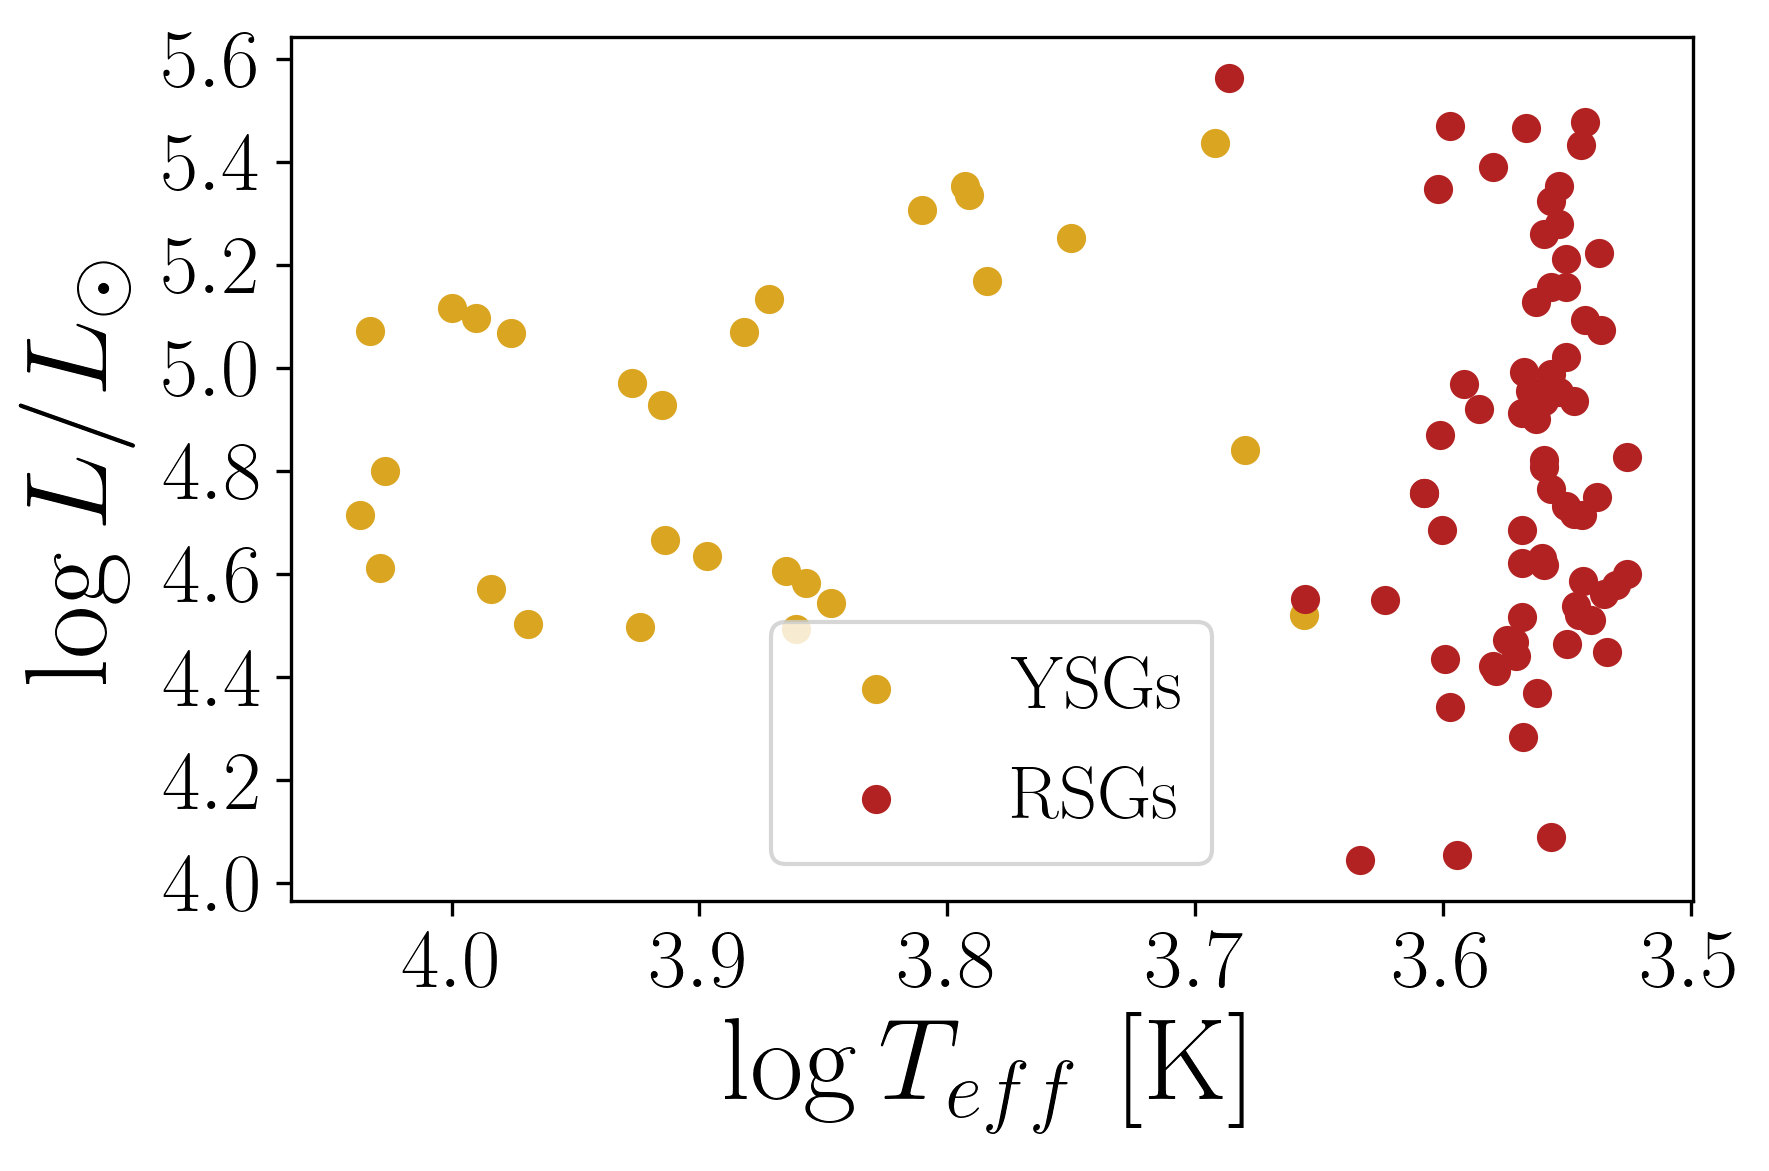

In [6]:
fig = plt.figure(dpi=300)
plt.scatter(ysg_spec['teff'],ysg_spec['lum'],c='goldenrod',label='YSGs')
plt.scatter(rsg_spec['teff'],rsg_spec['lum'],c='firebrick',label='RSGs')
plt.gca().invert_xaxis()

plt.legend(fontsize=18)

plt.xlabel('$\log{T_{eff}}$ [K]')
plt.ylabel('$\log{L/L_\odot}$')

ax= plt.gca()
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

plt.tight_layout()
plt.savefig('../plots/cool_sg.pdf')

# All these stars have TESS obervations, so let's look at them!

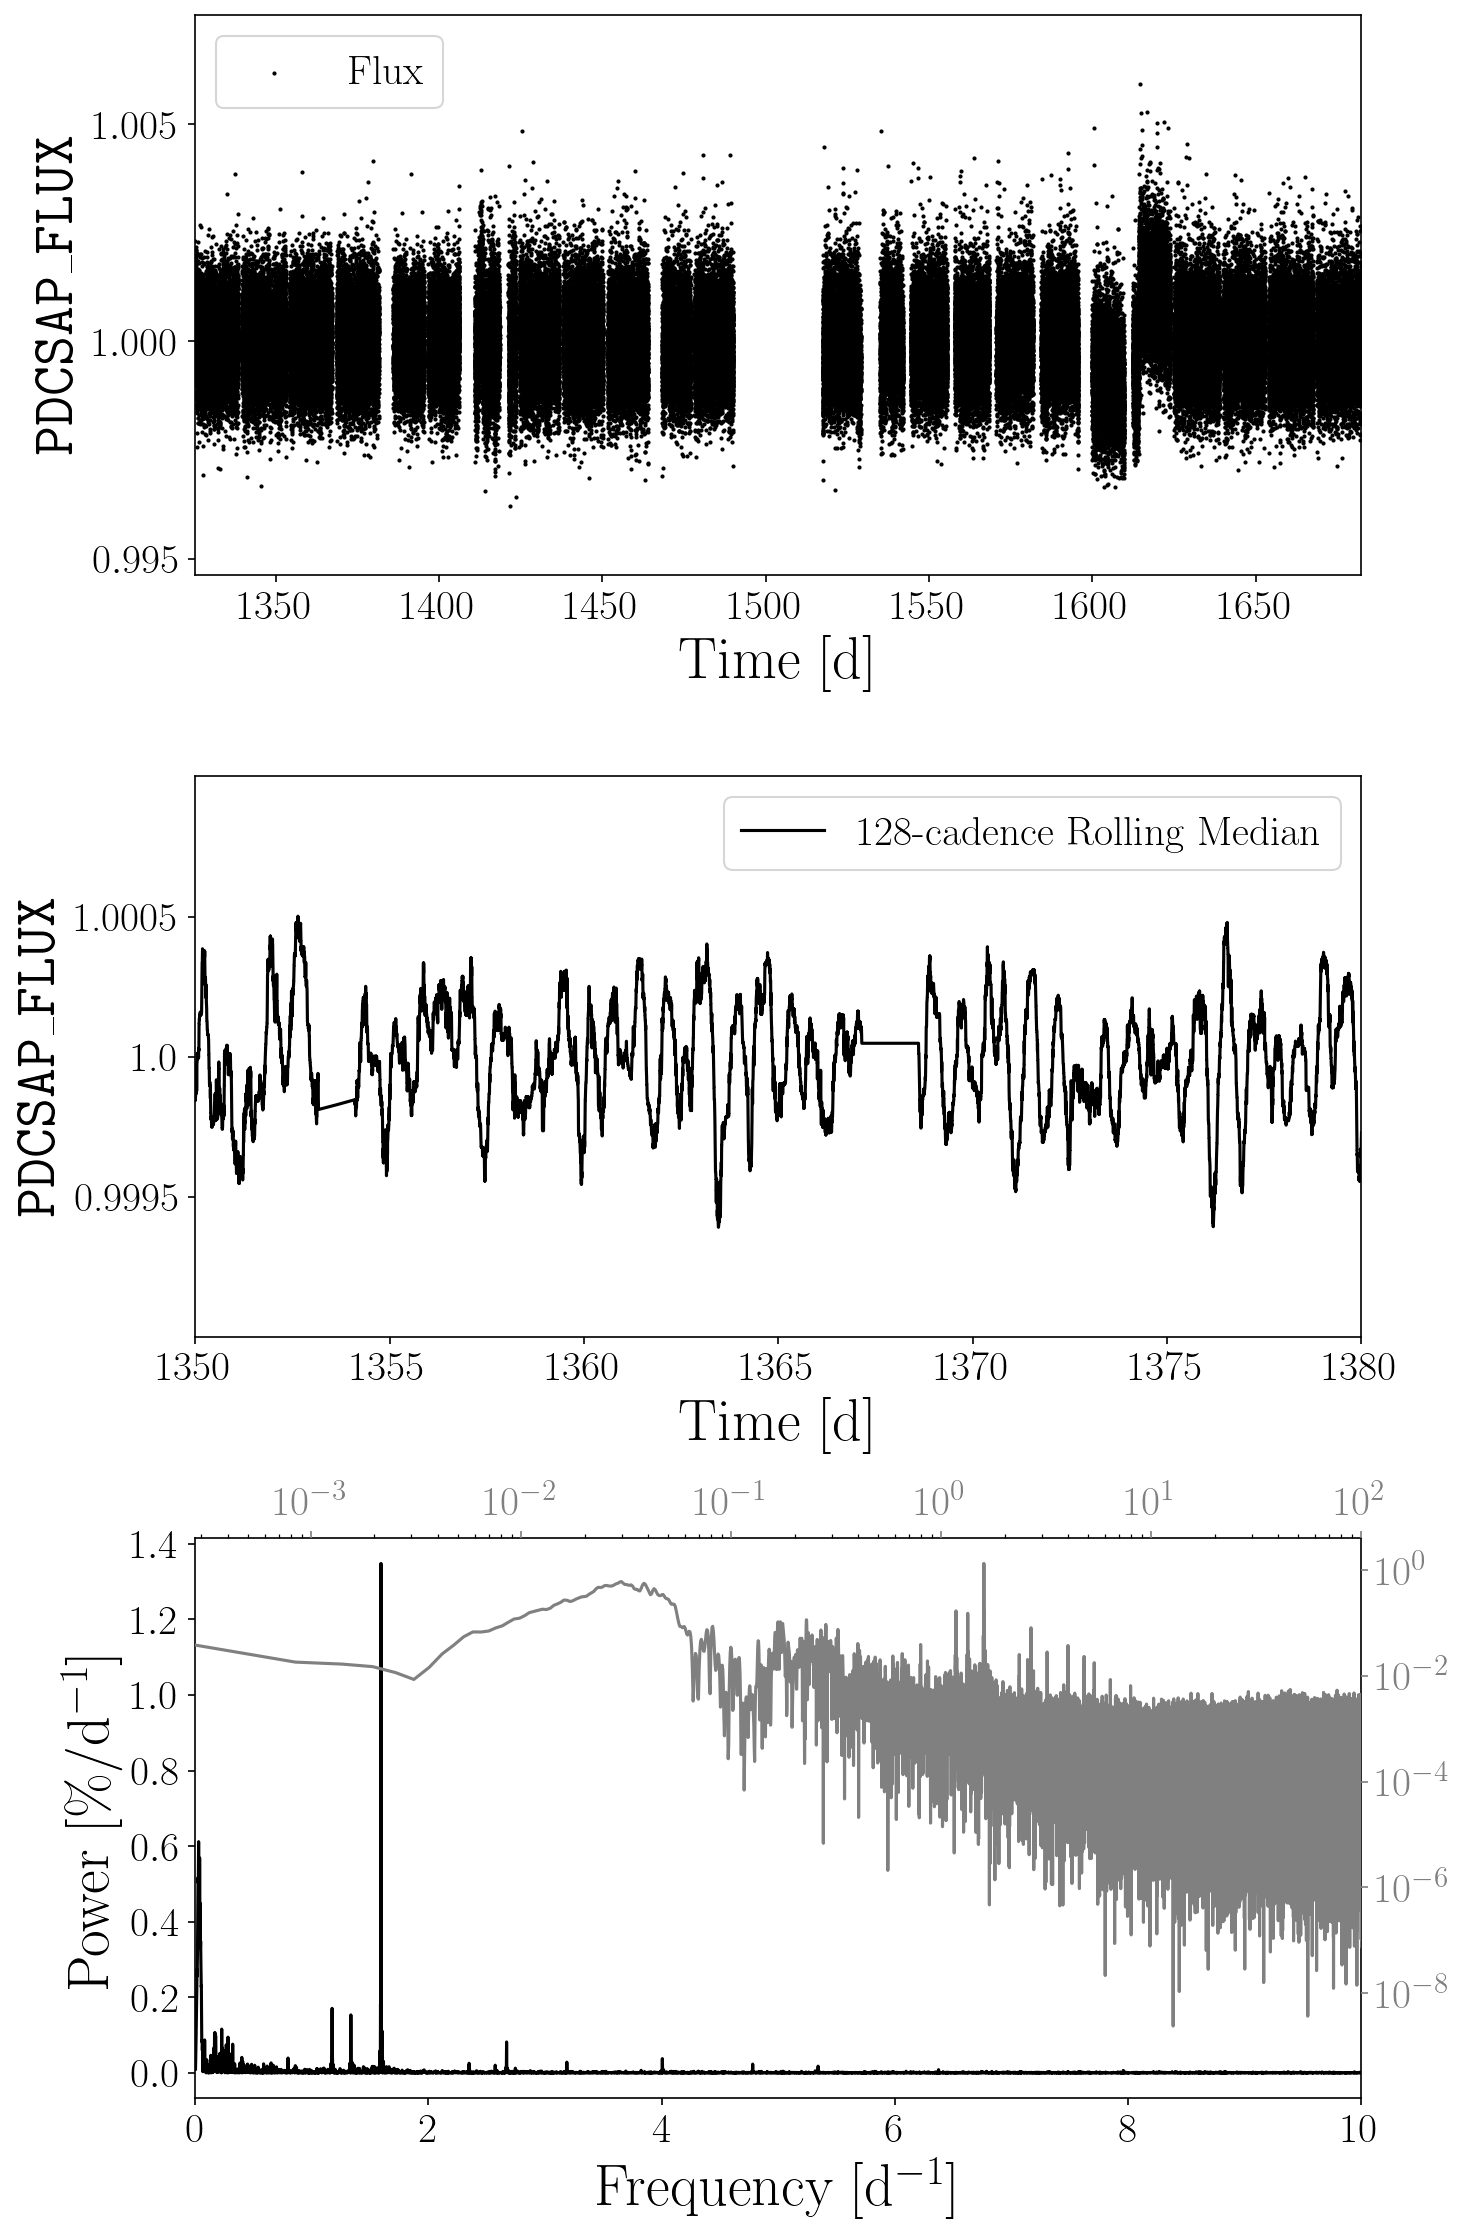

In [25]:
test_star = cool_sgs[cool_sgs['CommonName'] == 'HD 269953']
tic = test_star['TIC ID'].values[0]

lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
ls = LombScargle(time,flux,dy=err)
freq,power=ls.autopower(normalization='psd')
power /= len(time)

fig, axes = plt.subplots(3,figsize=(10,15),dpi=150)

axes[0].scatter(time, flux, c='k', s=1, label='Flux',rasterized=True)
axes[0].set(xlabel='Time [d]', ylabel=r'$\texttt{PDCSAP\_FLUX}$',xlim=(time.min(),time.max()))
axes[0].set_yticks([0.995,1,1.005])
axes[0].legend(fontsize=20)

axes[1].plot(lc_smooth['Time'], lc_smooth['Flux'], c='k', label='128-cadence Rolling Median',rasterized=True)
axes[1].set(xlabel='Time [d]', ylabel=r'$\texttt{PDCSAP\_FLUX}$', xlim=(1350,1380),ylim=(0.999,1.001))
axes[1].set_yticks(ticks=[0.9995,1,1.0005])
axes[1].set_yticklabels([0.9995,1.0000,1.0005])
axes[1].legend(fontsize=20)

logax = fig.add_subplot(313, label="1", frame_on=False)
logax.set(xlim=(freq.min(),1e2))
logax.loglog(freq,power*100,c='grey',rasterized=True)
logax.tick_params(axis='x', colors='grey')
logax.tick_params(axis='y', colors='grey')
logax.xaxis.set_label_position('top') 
logax.yaxis.set_label_position('right') 
logax.xaxis.tick_top()
logax.yaxis.tick_right()
logax.set_yticks([10**i for i in [-8,-6,-4,-2,0]])
logax.set_yticklabels([f'$10^{{{i}}}$' for i in [-8,-6,-4,-2,0]],fontdict={'fontsize':20})
logax.set_xticks([10**i for i in [-3,-2,-1,0,1,2]])
logax.set_xticklabels([f'$10^{{{i}}}$' for i in [-3,-2,-1,0,1,2]],fontdict={'fontsize':20})

axes[2].plot(freq,power*100,c='k')
axes[2].set(xlabel='Frequency [d$^{-1}$]',ylabel=r'Power [$\%$/d$^{-1}$]',xlim=(0,10))

for ax in axes.flatten():
    ax.xaxis.label.set_size(28)
    ax.yaxis.label.set_size(28)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
plt.tight_layout()
    
plt.savefig('../plots/hd269953_example.pdf')

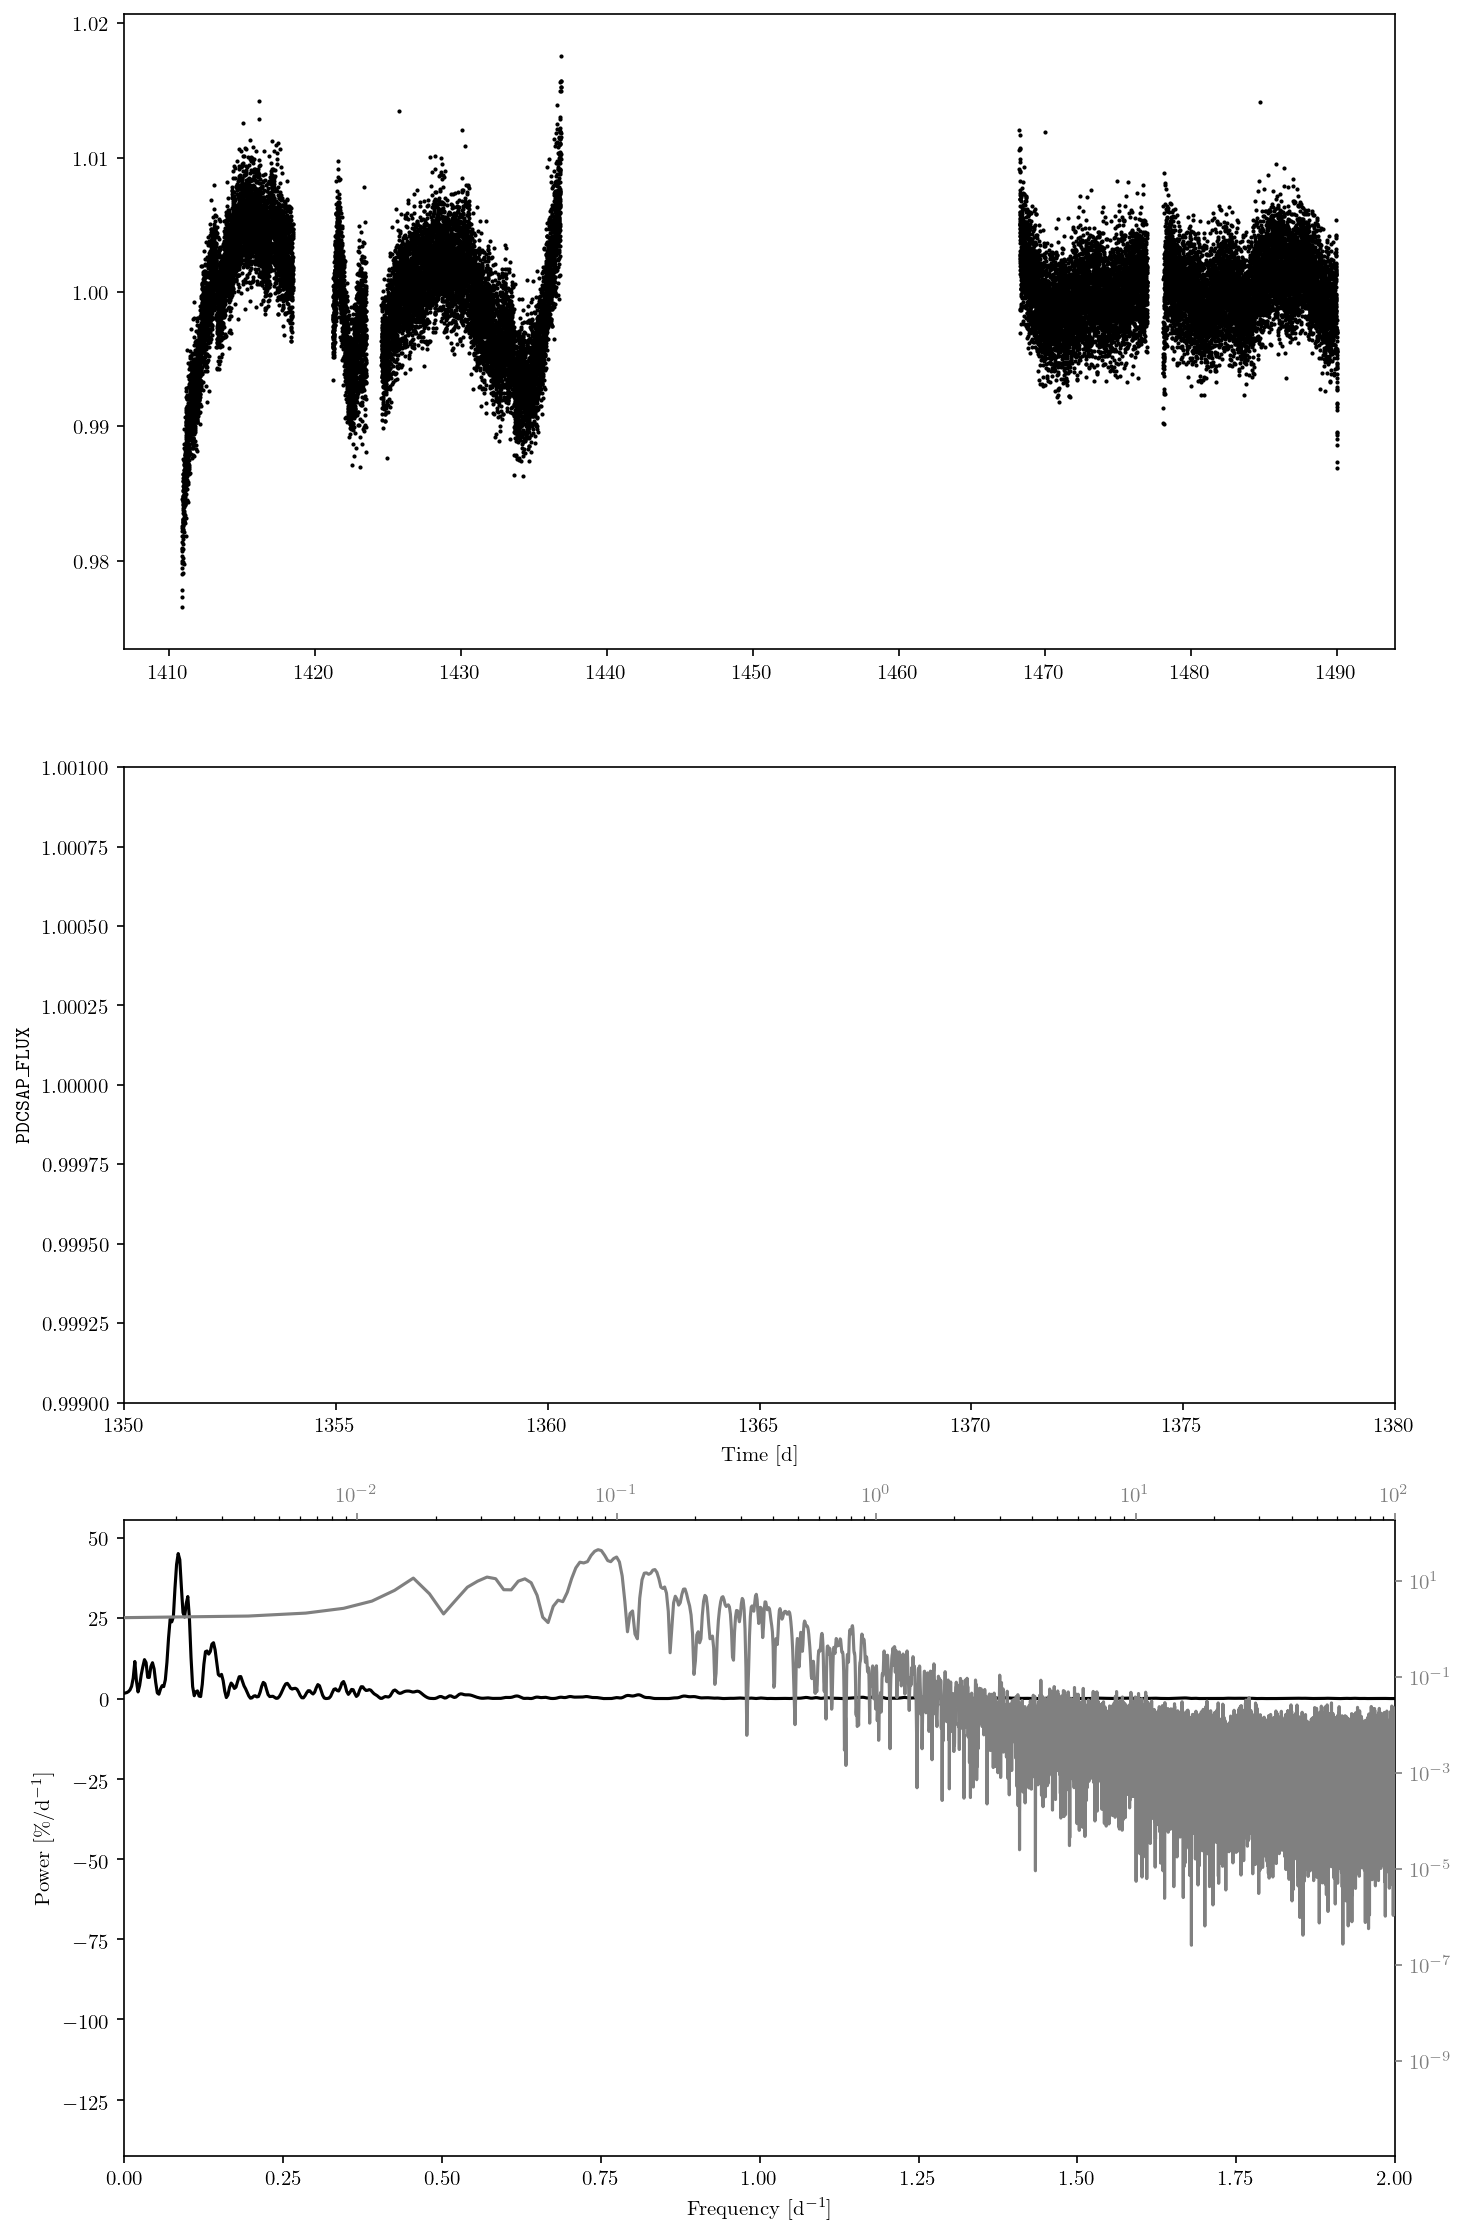

In [64]:
test_star = cool_sgs[cool_sgs['CommonName'] == 'SV* HV   883']
tic = test_star['TIC ID'].values[0]

lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
ls = LombScargle(time,flux,dy=err)
freq,power=ls.autopower(normalization='psd')
power /= len(time)

fig, axes = plt.subplots(3,figsize=(10,15),dpi=150)

axes[0].scatter(time, flux, c='k', s=1, label='Flux',rasterized=True)


axes[1].plot(lc_smooth['Time'], lc_smooth['Flux'], c='k', label='128-cadence Rolling Median',rasterized=True)
axes[1].set(xlabel='Time [d]', ylabel=r'$\texttt{PDCSAP\_FLUX}$', xlim=(1350,1380),ylim=(0.999,1.001))

logax = fig.add_subplot(313, label="1", frame_on=False)
logax.set(xlim=(freq.min(),1e2))
logax.loglog(freq,power*100,c='grey',rasterized=True)
logax.tick_params(axis='x', colors='grey')
logax.tick_params(axis='y', colors='grey')
logax.xaxis.set_label_position('top') 
logax.yaxis.set_label_position('right') 
logax.xaxis.tick_top()
logax.yaxis.tick_right()

axes[2].plot(freq,power*100,c='k')
axes[2].set(xlabel='Frequency [d$^{-1}$]',ylabel=r'Power [$\%$/d$^{-1}$]',xlim=(0,2))
    
plt.tight_layout()

In [60]:
cool_sgs['CommonName'].values

array(['V* V1092 Cen', 'V* HS Cas', 'HD 143183', 'BD+35  4077',
       'V* AD Per', 'V* KY Cyg', 'TYC 8626-2180-1', 'V* V589 Cas',
       'V* RS Per', 'V* V602 Car', 'V* W Per', 'V* V396 Cen', 'V* BI Cyg',
       'V* BC Cyg', 'V* SU Per', 'V* PZ Cas', 'V* ST Cep', 'V* RW Cyg',
       'V* TZ Cas', 'V* BU Per', 'V* V349 Car', 'V* V774 Cas',
       'HD  95687', 'V* V441 Per', 'HD 303250', 'V* RT Car',
       'V* V772 Cen', 'HD 101007', 'V* V648 Cas', 'V* IX Car', 'V* W Cep',
       'V* V910 Cen', 'V* V528 Car', 'V* YZ Per', 'V* V362 Aur',
       'V* PR Per', 'V* FZ Per', 'V* V809 Cas', 'V* V439 Per',
       'V* V605 Cas', '*  41 Gem', 'V* RW Cep', 'HD 155603', 'V* NR Vul',
       'V* QY Pup', 'HD  17958', 'HD  33299', 'V* AZ Cas', 'SK -67   57',
       'SV* HV   883', 'HD 269953', 'HD 269110', 'HD 268687', 'HD 269840',
       'HD 269902', 'HD 269331', 'RMC 137', 'CPD-69   430', 'W61 27-27',
       'HD 269392', 'HD 269128', 'HD 269700', 'HD 270151', 'CPD-69   491',
       'HD 270754', 'HD 

## What about all of their periodograms?

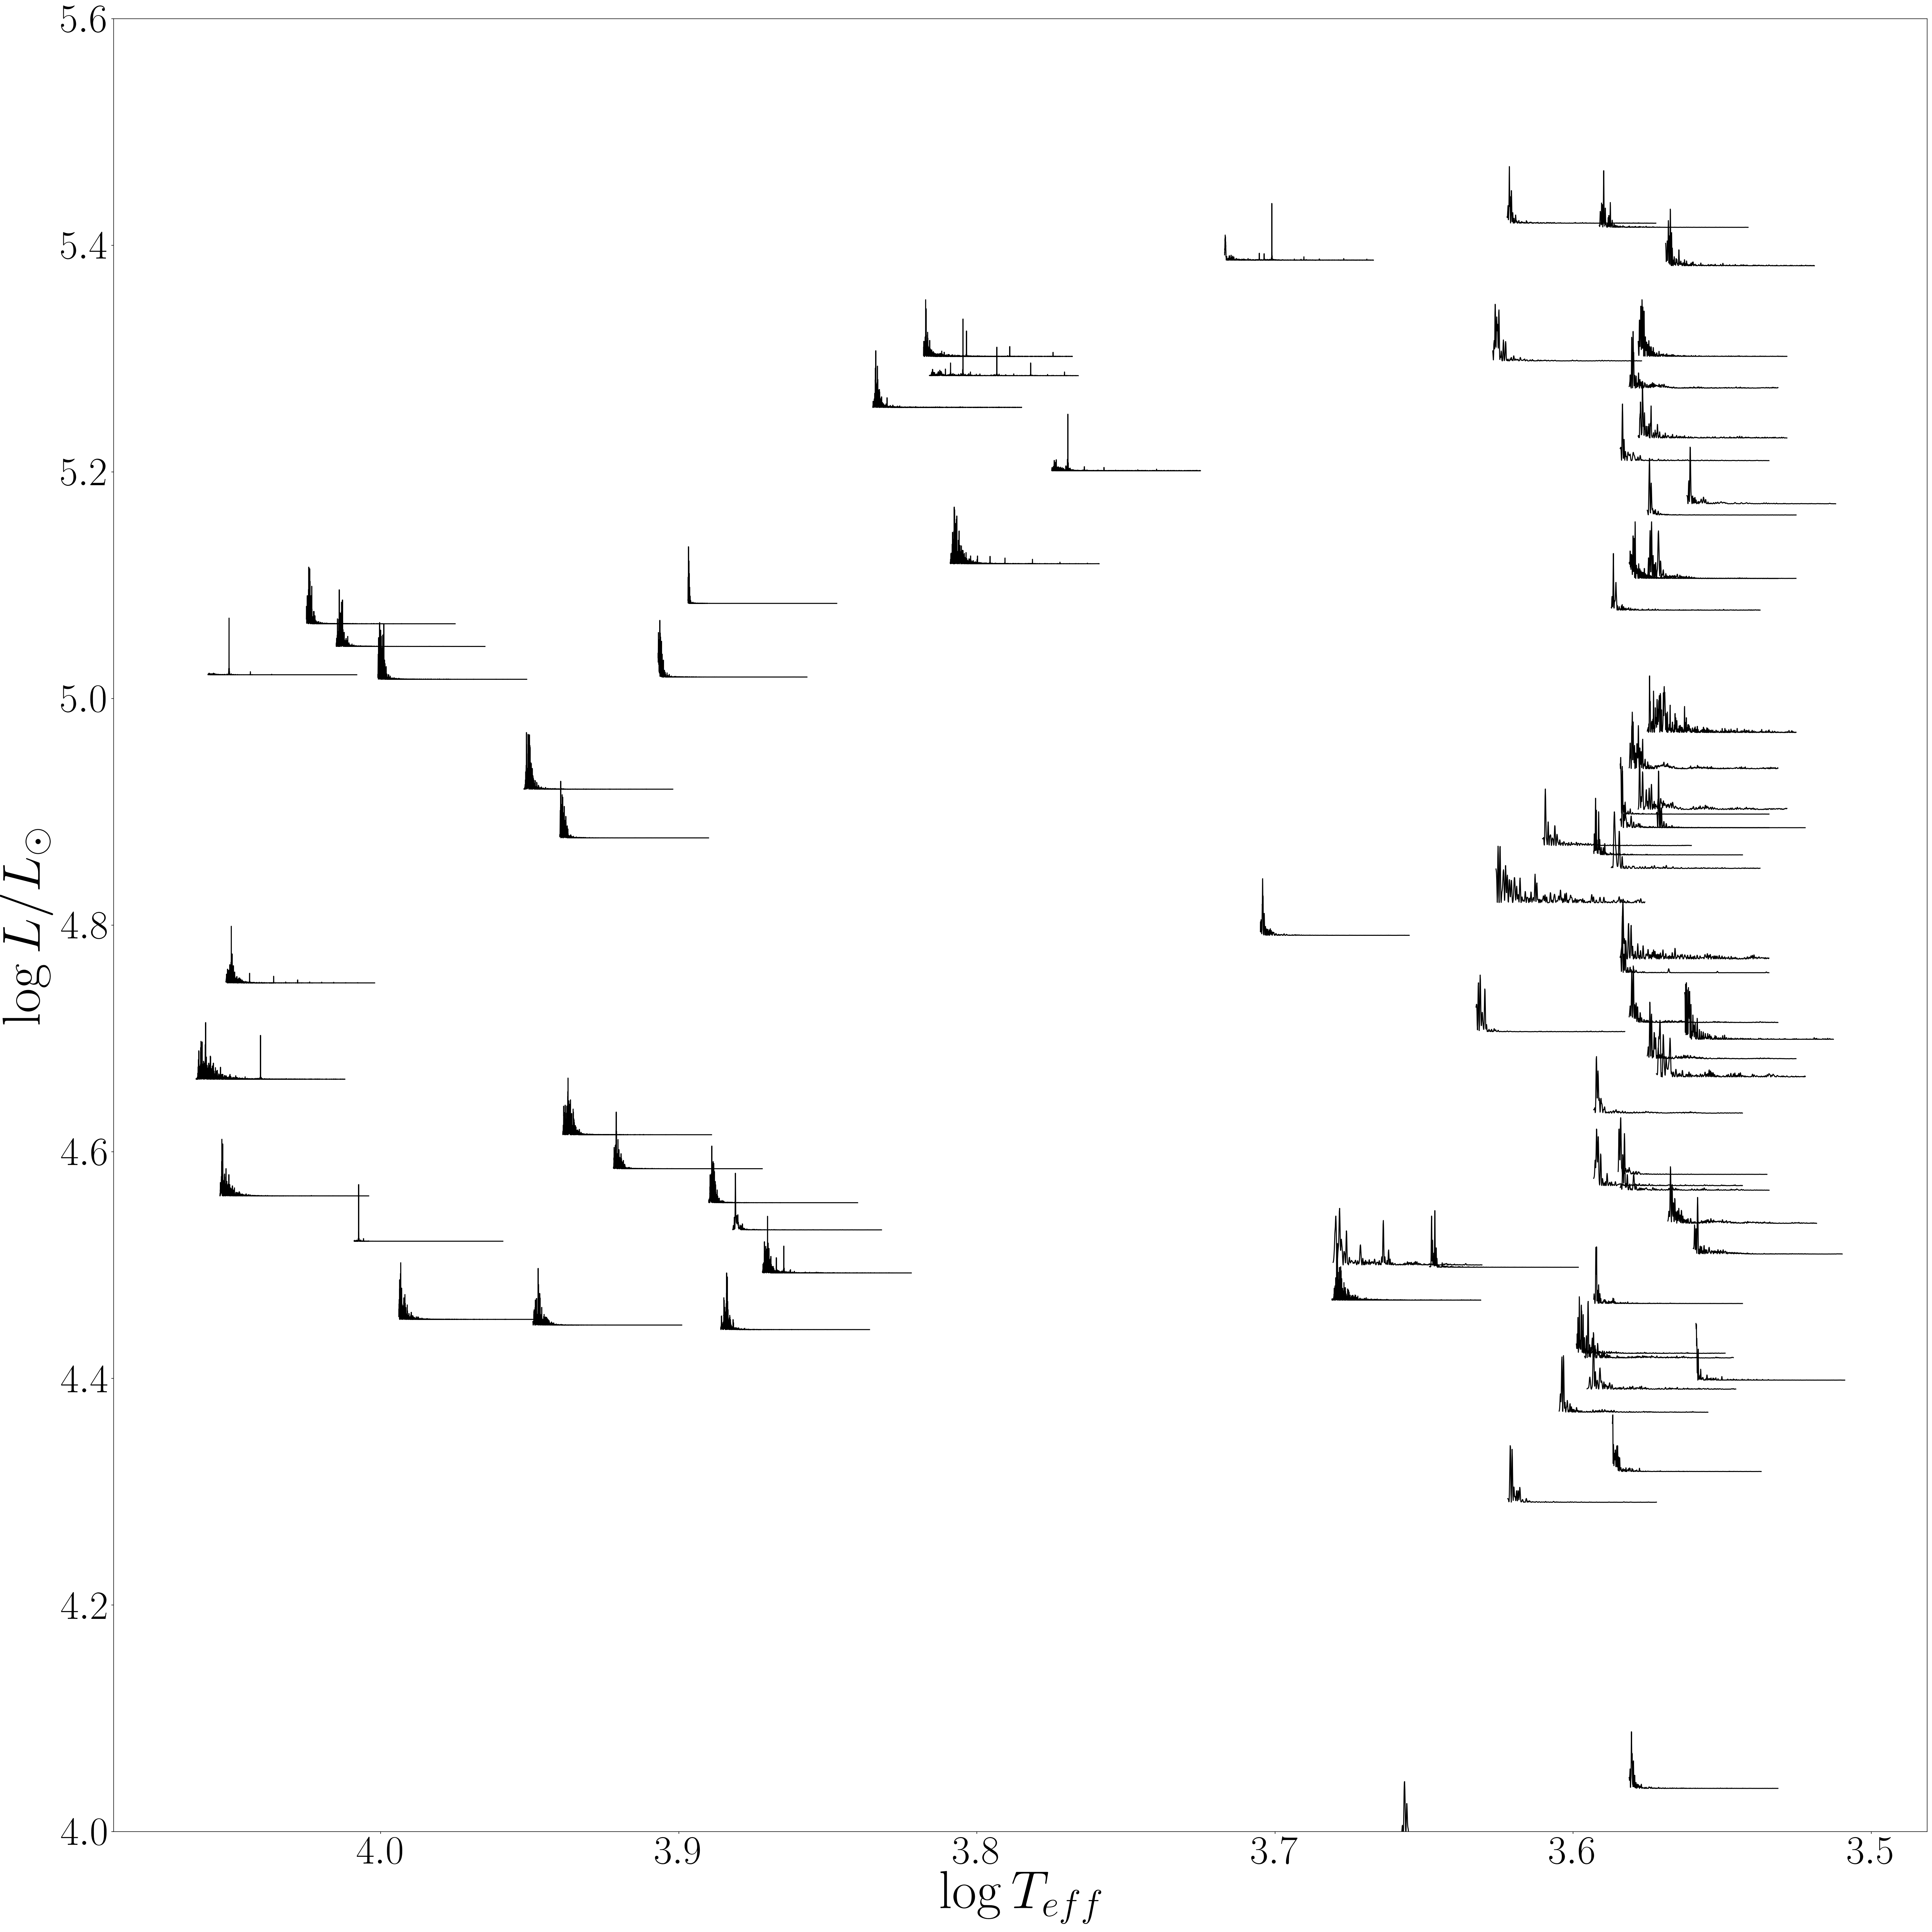

In [26]:
fig = plt.figure(figsize=(40,40),dpi=150)
for j,star in tqdm(cool_sgs.iterrows(), total=len(cool_sgs)):
    lc, lc_smooth = lc_extract(get_lc_from_id(star['TIC ID']), smooth=128)
    time, flux, err = lc['Time'], lc['Flux'], lc['Err']
    ls = LombScargle(time,flux,dy=err)
    freq,power=ls.autopower(minimum_frequency=0.01,maximum_frequency=5,normalization='psd')
    power /= len(time)
    x = star['teff']
    y = star['lum']
    plt.plot(0.01*(-freq + 2.5) + x,0.05*(power/power.max()) - 0.05 + y,c='k')
    #plt.text(x-0.005, y,star['CommonName'].lstrip('V*').lstrip(),fontdict={'fontsize':20})
ax = plt.gca()
ax.invert_xaxis()
ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',ylim=(4.0,5.6))
ax.xaxis.label.set_size(80)
ax.yaxis.label.set_size(80)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(60)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(60)
    
plt.tight_layout()
plt.savefig('../plots/periodogram_hr.pdf')

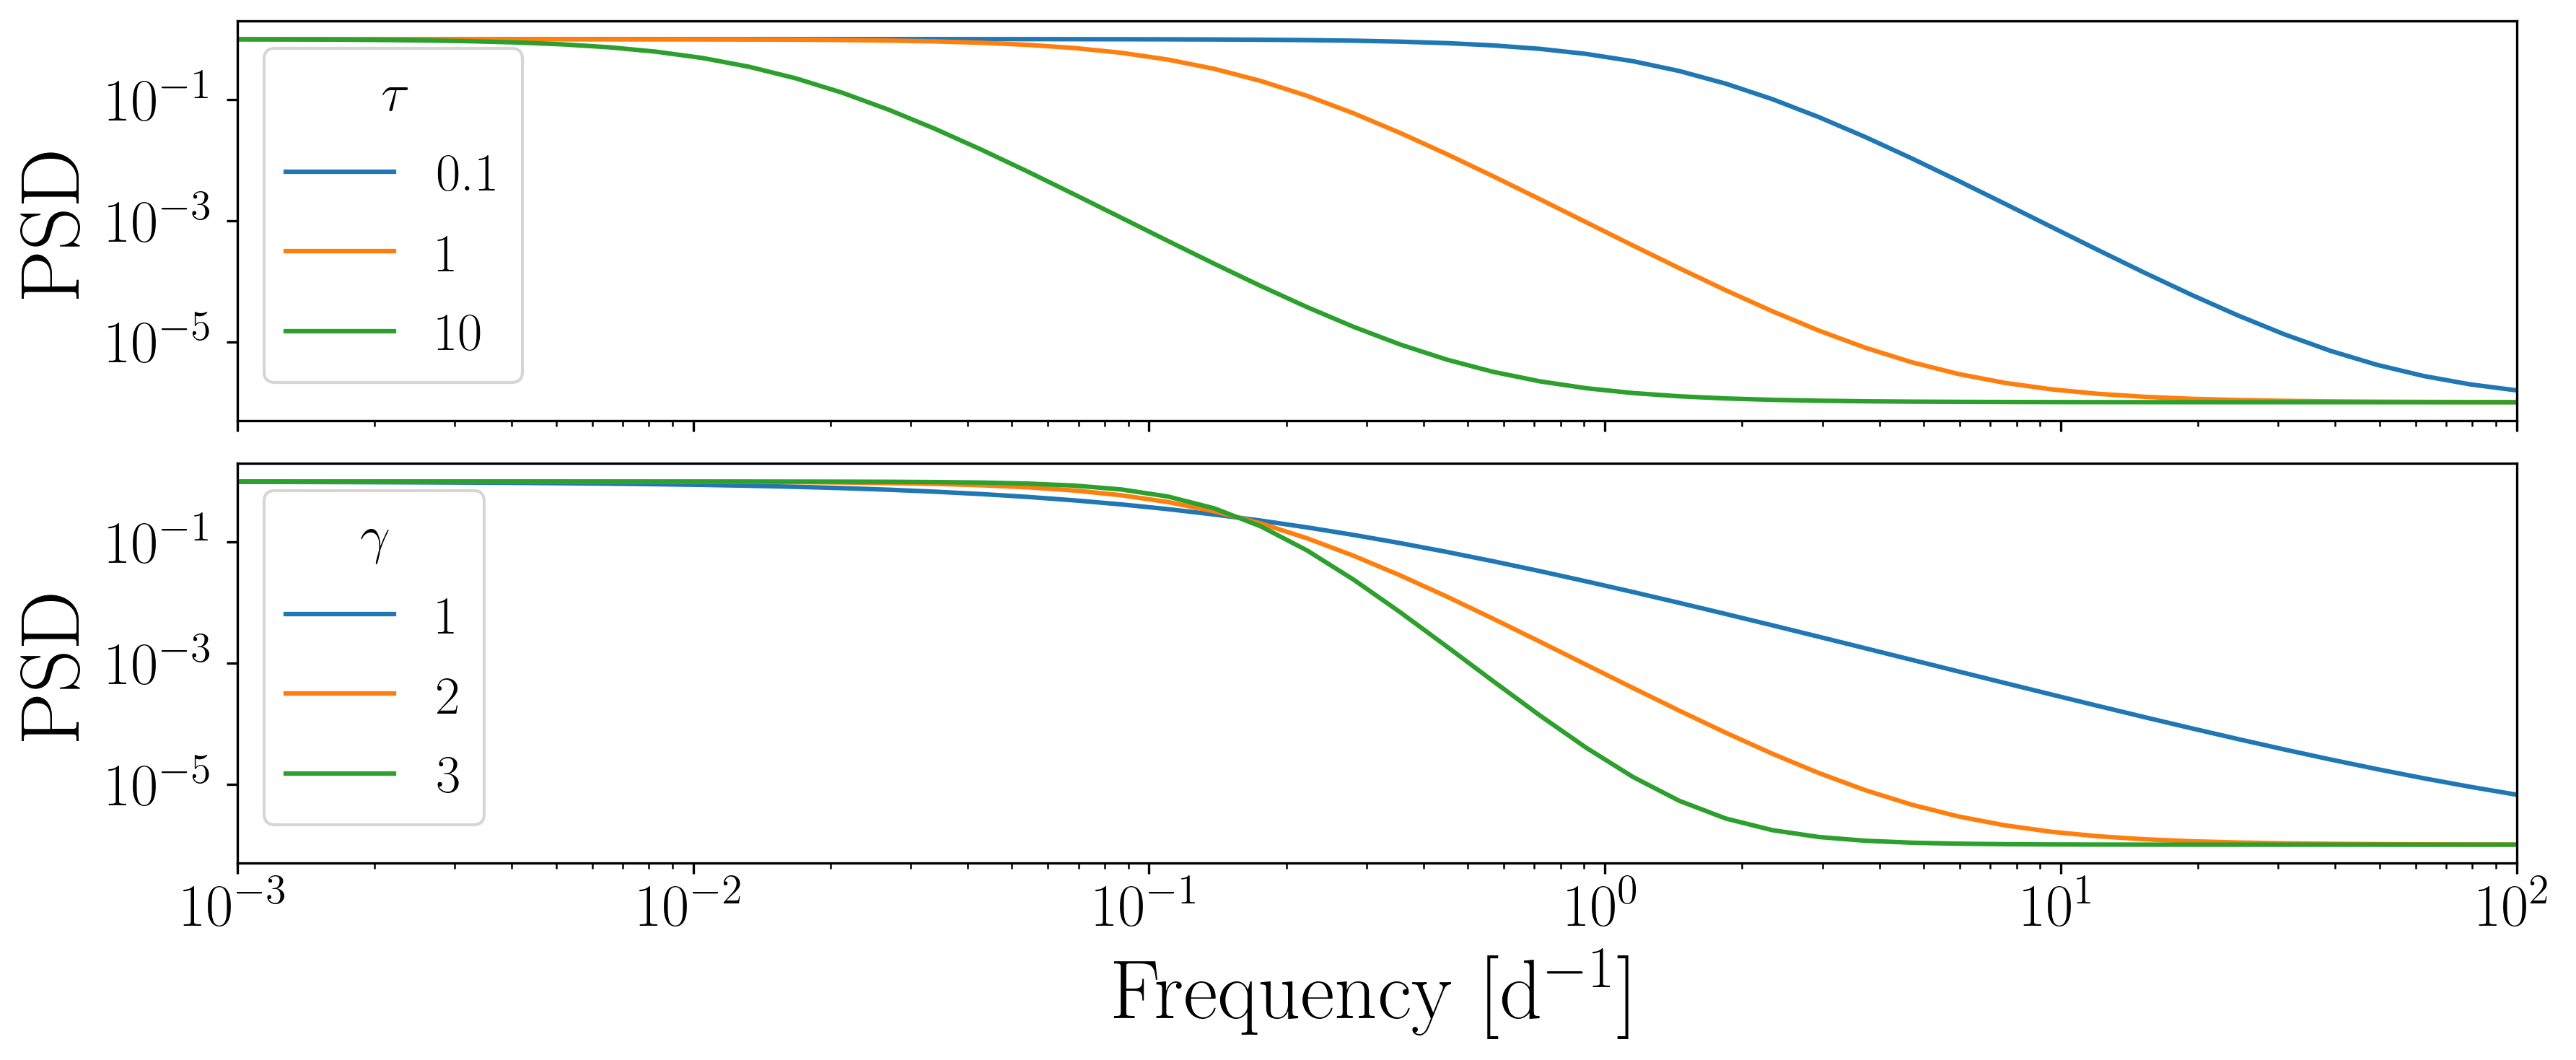

In [27]:
fig,axes = plt.subplots(2,figsize=(12,5),sharex=True,dpi=300)
fs = np.logspace(-3,2)
for tau in [0.1,1,10]:
    axes[0].loglog(fs,noise_func(fs,1,tau,2,1e-3)**2.0,label=tau)
    
for gamma in [1,2,3]:
    axes[1].loglog(fs,noise_func(fs,1,1,gamma,1e-3)**2.0,label=gamma)

axes[0].set(ylabel='PSD',xlim=(1e-3,1e2))
axes[1].set(xlabel='Frequency [d$^{-1}$]',ylabel='PSD',xlim=(1e-3,1e2))

leg1 = axes[0].legend(title=r'$\tau$',fontsize=18)
leg2 = axes[1].legend(title=r'$\gamma$',fontsize=18)

leg1.get_title().set_fontsize('18')
leg2.get_title().set_fontsize('18')

for ax in axes.flatten():
    ax.xaxis.label.set_size(28)
    ax.yaxis.label.set_size(28)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
plt.tight_layout()
plt.savefig('../plots/noise_func.pdf')

In [28]:
popts = []
errs = []
freqs = []
resids = []
import warnings
from tqdm.notebook import tqdm
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for j,star in tqdm(cool_sgs.iterrows(), total=len(cool_sgs)):
        lc, lc_smooth = lc_extract(get_lc_from_id(star['TIC ID']), smooth=128)
        time, flux, err = lc['Time'], lc['Flux'], lc['Err']
        ls = LombScargle(time,flux,dy=err)
        freq,power=ls.autopower(normalization='psd')
        power /= len(time) #correct units
        try:
            popt, pcov, resid = fit_red_noise(freq, power)
        except RuntimeError:
            popt, pcov, resid = fit_red_noise(freq[freq < 50], power[freq < 50])
            freq = freq[freq < 50]
        popts.append(popt)
        errs.append(np.sqrt(np.diag(pcov)))
        frequency_range = (freq >= 0.1) & (freq <= 5)
        resid_range = resid[frequency_range]
        freq_range = freq[frequency_range]
        freqs.append(freq_range)
        resids.append(resid_range)

In [29]:
popts = np.array(popts)
errs = np.array(errs)
freqs = np.array(freqs)
resids = np.array(resids)
alphas = popts[:,0]
ealphas = errs[:,0]
taus = popts[:,1]
etaus = errs[:,1]
gammas = popts[:,2]
egammas = errs[:,2]
alpha_w = popts[:,3]
ealpha_w = errs[:,3]

cool_sgs['alpha'] = alphas
cool_sgs['e_alpha'] = ealphas
cool_sgs['tau'] = taus
cool_sgs['e_tau'] = etaus
cool_sgs['gamma'] = gammas
cool_sgs['e_gamma'] = egammas
cool_sgs['alpha_w'] = alpha_w
cool_sgs['e_alpha_w'] = ealpha_w
cool_sgs.to_csv('cool_supergiants_TESS.csv',index=False)

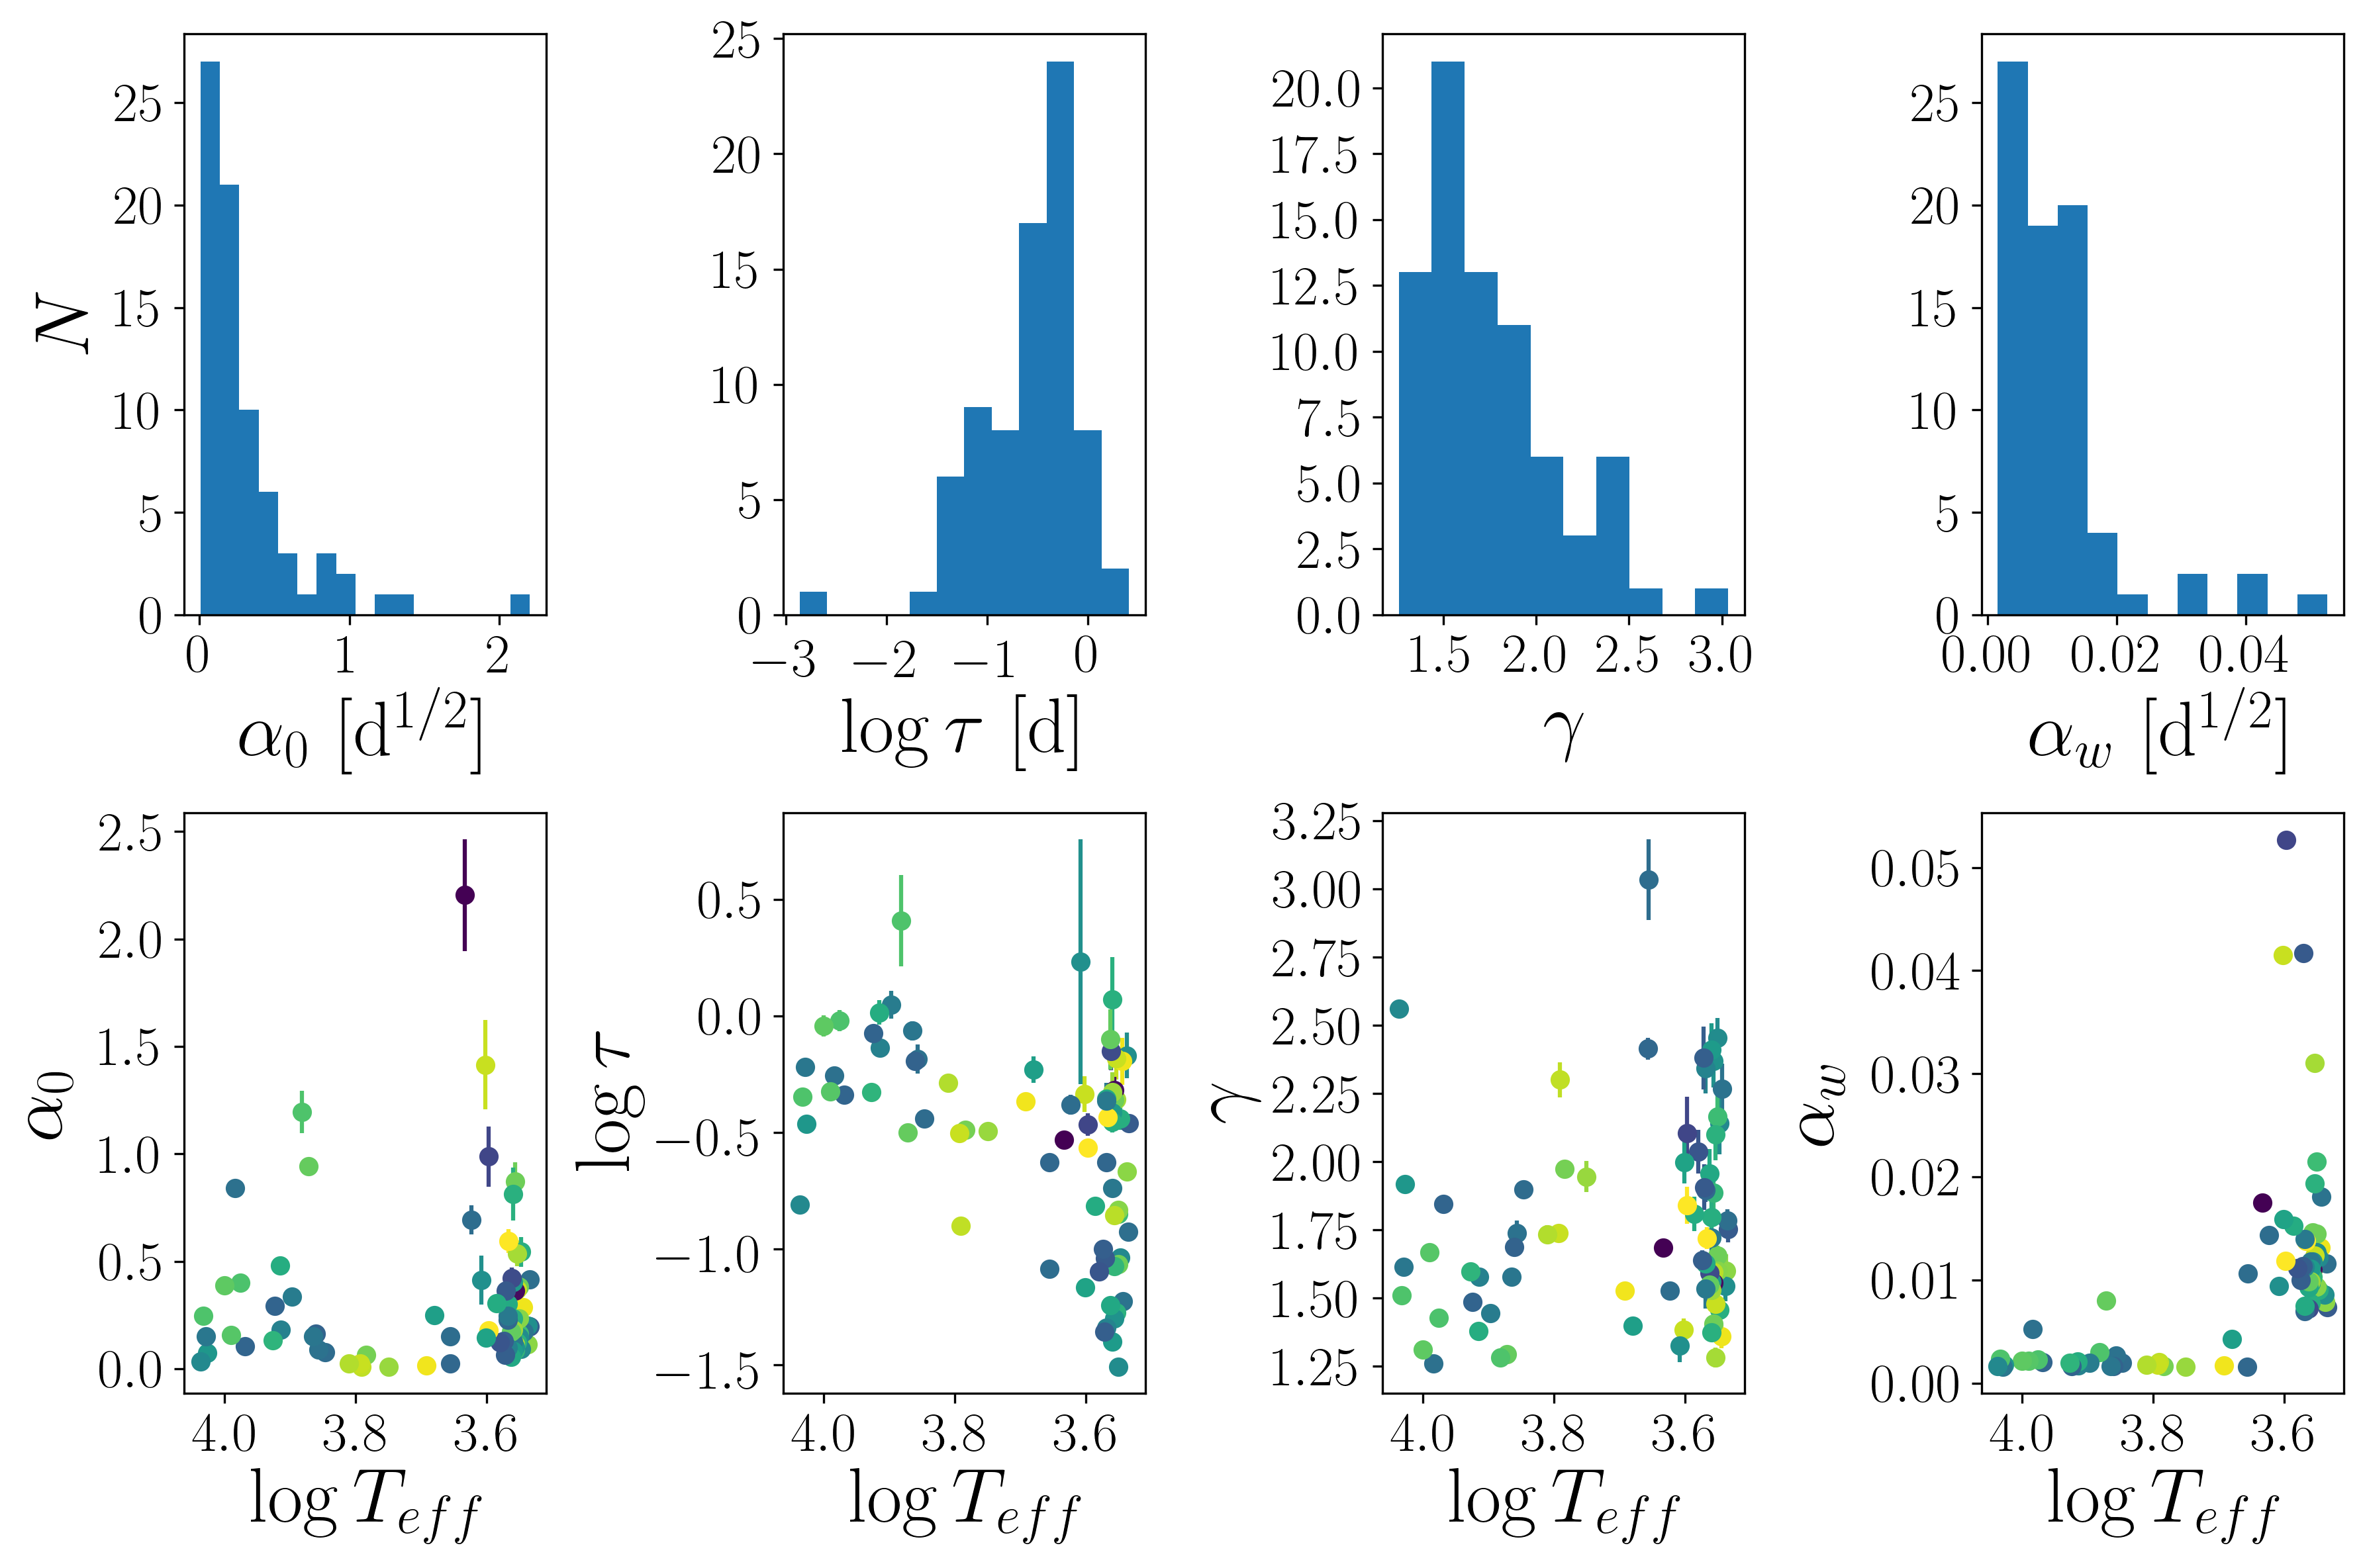

In [30]:
#distributions of fit parameters. Only cool thing: RSGs have slope ~2, consistent with... Love? Someone?
fig, axes = plt.subplots(2, 4, figsize=(12,8), dpi=300)
cmap = cm.get_cmap('viridis')
norm = colors.Normalize(vmin=cool_sgs['lum'].min(),vmax=cool_sgs['lum'].max())

axes[0,0].hist(alphas, bins='auto')
axes[0,1].hist(np.log10(taus), bins='auto')
axes[0,2].hist(gammas[gammas > 0], bins='auto')
axes[0,3].hist(alpha_w, bins='auto')
for j,star in cool_sgs.iterrows():
    if star['gamma'] > 0:
        axes[1,0].errorbar(star['teff'],star['alpha'],yerr=star['e_alpha'],fmt='o',c=cmap(norm(star['lum'])))
        axes[1,1].errorbar(star['teff'],np.log10(star['tau']),yerr=star['e_tau'],fmt='o',c=cmap(norm(star['lum'])))
        axes[1,2].errorbar(star['teff'],star['gamma'],yerr=star['e_gamma'],fmt='o',c=cmap(norm(star['lum'])))
        axes[1,3].errorbar(star['teff'],star['alpha_w'],yerr=star['e_alpha_w'],fmt='o',c=cmap(norm(star['lum'])))
    
axes[0,0].set(xlabel=r'$\alpha_0$ [d$^{1/2}$]',ylabel='$N$')
axes[0,1].set(xlabel=r'$\log\tau$ [d]')
axes[0,2].set(xlabel=r'$\gamma$')
axes[0,3].set(xlabel=r'$\alpha_w$ [d$^{1/2}$]')

axes[1,0].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\alpha_0$')
axes[1,1].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\log\tau$')
axes[1,2].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\gamma$')
axes[1,3].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\alpha_w$')

for ax in axes.flatten():
    ax.xaxis.label.set_size(28)
    ax.yaxis.label.set_size(28)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
        
for ax in axes[1,:]:
    ax.invert_xaxis()

plt.tight_layout()

plt.savefig('../plots/fit_params.pdf')

In [186]:
pd.read_table('../data/Geneva/M009Z02V0.dat',skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
            index_col='line',delim_whitespace=True)#sep=r"\s*")

time      mass     lg(L)  lg(Teff)   1H_surf  4He_surf  \
line                                                                   
1     2.560058e+05  8.999978  3.631524  4.444603  0.747086  0.250873   
2     8.758387e+05  8.999932  3.636223  4.440842  0.747086  0.250873   
3     1.466156e+06  8.999887  3.641173  4.439948  0.747086  0.250873   
4     2.056473e+06  8.999840  3.646227  4.439520  0.747086  0.250873   
5     2.632032e+06  8.999793  3.651111  4.439193  0.747086  0.250873   
...            ...       ...       ...       ...       ...       ...   
396   2.899688e+07  8.845414  4.440688  3.607534  0.734156  0.263797   
397   2.899688e+07  8.845414  4.440688  3.607534  0.734156  0.263797   
398   2.899688e+07  8.845414  4.440688  3.607534  0.734156  0.263797   
399   2.899688e+07  8.845414  4.440688  3.607534  0.734156  0.263797   
400   2.899688e+07  8.845414  4.440688  3.607534  0.734156  0.263797   

      12C_surf  13C_surf  14N_surf  16O_surf  ...  Omeg_cen  Rp/Req   \
line                                          ...                      
1     0.000326  0.000004  0.000094  0.000817  ...       0.0      1.0   
2     0.000326  0.000004  0.000094  0.000817  ...       0.0      1.0   
3     0.000326  0.000004  0.000094  0.000817  ...       0.0      1.0   
4     0.000326  0.000004  0.000094  0.000817  ...       0.0      1.0   
5     0.000326  0.000004  0.000094  0.000817  ...       0.0      1.0   
...        ...       ...       ...       ...  ...       ...      ...   
396   0.000165  0.000009  0.000353  0.000727  ...       0.0      1.0   
397   0.000165  0.000009  0.000353  0.000727  ...       0.0      1.0   
398   0.000165  0.000009  0.000353  0.000727  ...       0.0      1.0   
399   0.000165  0.000009  0.000353  0.000727  ...       0.0      1.0   
400   0.000165  0.000009  0.000353  0.000727  ...       0.0      1.0   

      Md/Md(0)  v_crit1  v_crit2  v_equa  Om/Om_cr  Gamma_Ed  lg(Mdot_mech)  \
line                                                                          
1          1.0      0.0      0.0     0.0       0.0  0.012774            0.0   
2          1.0      0.0      0.0     0.0       0.0  0.012913            0.0   
3          1.0      0.0      0.0     0.0       0.0  0.013061            0.0   
4          1.0      0.0      0.0     0.0       0.0  0.013214            0.0   
5          1.0      0.0      0.0     0.0       0.0  0.013364            0.0   
...        ...      ...      ...     ...       ...       ...            ...   
396        1.0      0.0      0.0     0.0       0.0  0.083135            0.0   
397        1.0      0.0      0.0     0.0       0.0  0.083135            0.0   
398        1.0      0.0      0.0     0.0       0.0  0.083135            0.0   
399        1.0      0.0      0.0     0.0       0.0  0.083135            0.0   
400        1.0      0.0      0.0     0.0       0.0  0.083135            0.0   

      L_tot  
line         
1       0.0  
2       0.0  
3       0.0  
4       0.0  
5       0.0  
...     ...  
396     0.0  
397     0.0  
398     0.0  
399     0.0  
400     0.0  

[400 rows x 42 columns]

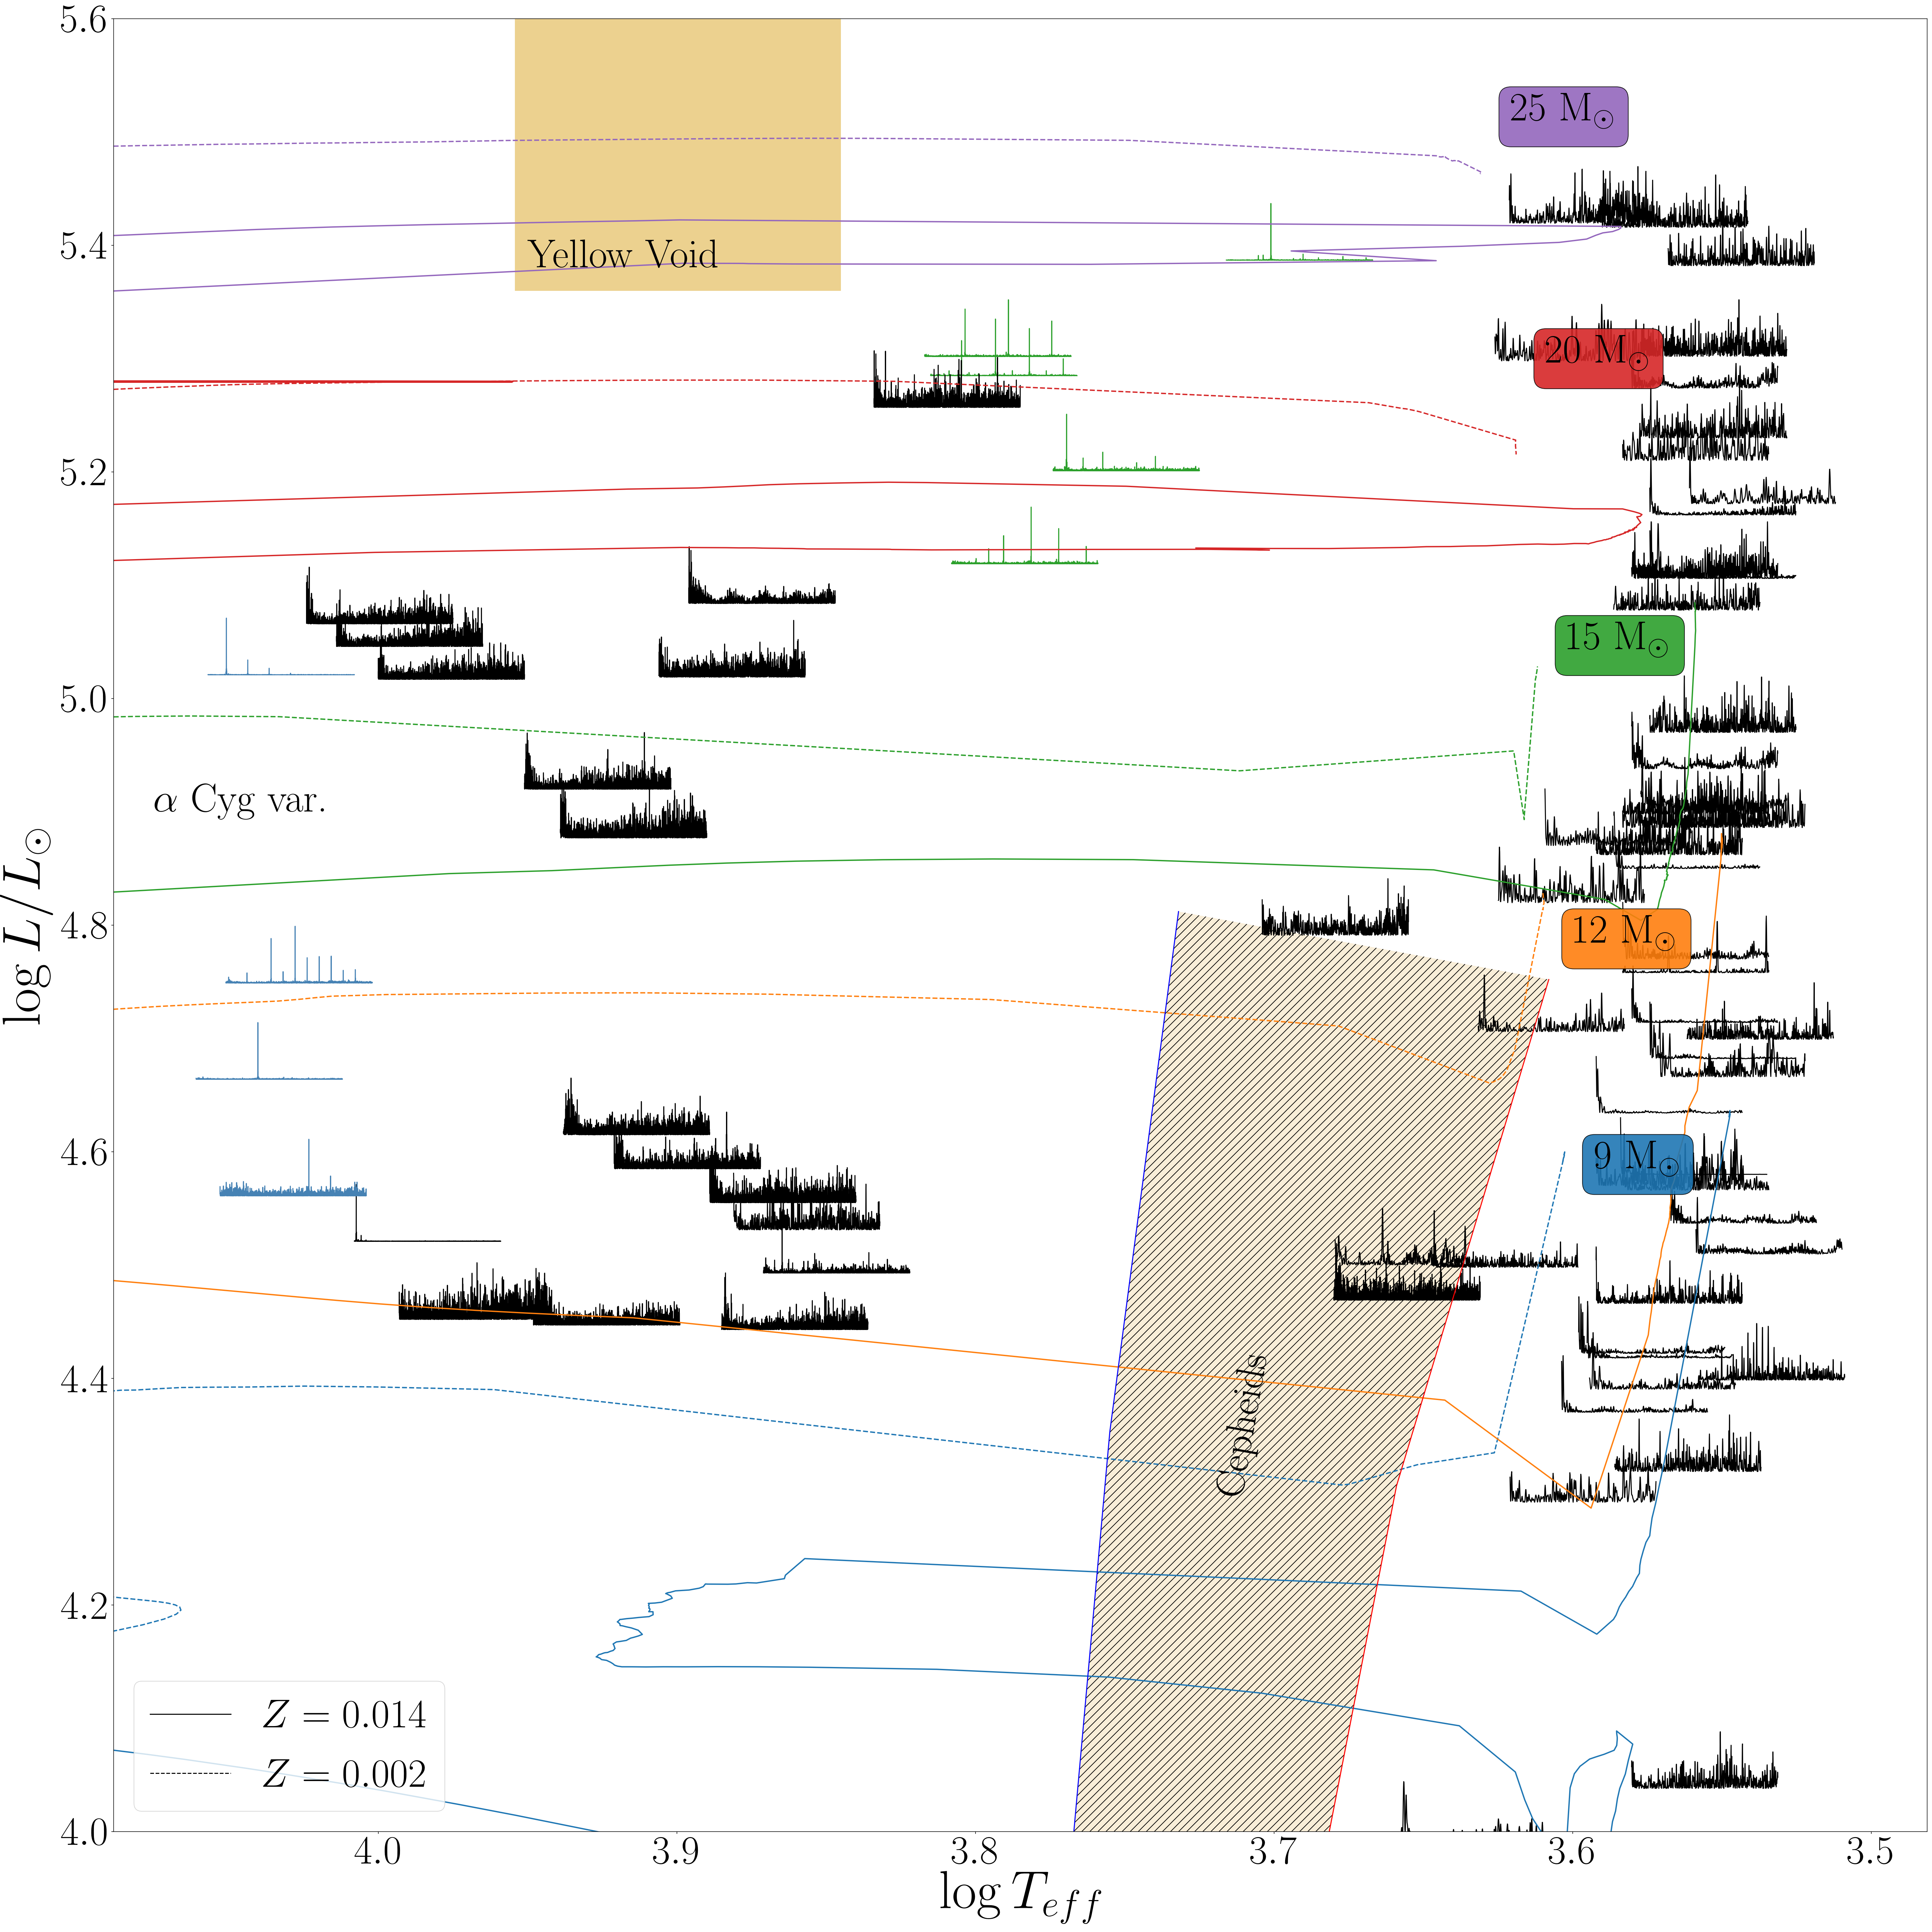

In [51]:
fig = plt.figure(figsize=(40,40),dpi=150)
fyps = cool_sgs[(cool_sgs['teff'] >= 3.69)&(cool_sgs['teff'] <= 3.8)&(cool_sgs['lum']>= 5.1)&(cool_sgs['lum']<=5.5)]
aceps = cool_sgs[(cool_sgs['teff'] >= 4.0)&(cool_sgs['lum'] <= 5.1)]

from matplotlib import lines as mlines

#Plot RPS
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for j,star in tqdm(cool_sgs.iterrows(), total=len(cool_sgs)):
        if star['TIC ID'] in fyps['TIC ID'].values:
            c = 'C2'
        elif star['TIC ID'] in aceps['TIC ID'].values:
            c='steelblue'
        else:
            c='k'
        x = star['teff']
        y = star['lum']
        plt.plot(0.01*(-freqs[j] + 2.5) + x,0.05*(resids[j]/resids[j].max()) - 0.05 + y,c=c)

#Invert Axes and get xlimits
ax = plt.gca()
ax.invert_xaxis()
xl = ax.get_xlim()

#Plot rotating Geneva tracks
for m,c in zip([9,12,15,20,25],[f'C{i}' for i in range(5)]):
    tab_smc = glob(f'../data/Geneva/M*{str(m).zfill(3)}*Z02V4.dat')[-1]
    tab_sol = glob(f'../data/Geneva/M*{str(m).zfill(3)}*Z14V4.dat')[-1]
    if m <= 25:
        if m >= 15:
            offset = 0.01
        elif m == 9:
            offset = -0.02
        elif m == 12:
            offset = -0.05
    for tab,ls in zip([tab_smc,tab_sol],['--','-']):
        g = pd.read_table(tab,skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
            index_col='line',delim_whitespace=True)
    
        plt.plot(g['lg(Teff)'],g['lg(L)'],lw=2,ls=ls,c=c)
        if ls =='--':
            plt.text(g['lg(Teff)'].min()-0.01,g['lg(L)'].max()+offset,
                     str(m)+r' M$_\odot$',fontdict={'fontsize':60},
                     bbox=dict(facecolor=c,boxstyle='round',alpha=0.9))


#Plot Cepheid strip
ln1 = plt.plot(instability_strip['logTeff1'],instability_strip['logL1'],c='b')
ln2 = plt.plot(instability_strip['logTeff2'],instability_strip['logL2'],c='r')
inst_t = np.array([s['logTeff1'] for _,s in instability_strip.iterrows()])
inst_l = np.array([s['logL1'] for _,s in instability_strip.iterrows()])
for i,s in instability_strip.iterrows():
    if i == 0:
        inst_t = np.append(inst_t,s['logTeff2'])
        inst_l = np.append(inst_l,s['logL2'])
    else:
        inst_t = np.insert(inst_t,-1*i,s['logTeff2'])
        inst_l = np.insert(inst_l,-1*i,s['logL2'])
coords = np.hstack((inst_t[:,np.newaxis],inst_l[:,np.newaxis]))
poly = plt.Polygon(coords,fc='wheat',alpha=0.5,hatch='//')
ax.add_patch(poly)
plt.text(3.72,4.3,'Cepheids',fontdict={'fontsize':60},rotation=80)

#Plot Yellow Void, label alpha Cygnis
yv = plt.axvspan(xmin=np.log10(7000),xmax=np.log10(9000),ymin=0.85,fc='goldenrod',alpha=0.5)
#ac = plt.axvspan(xmin=4,xmax=4.1,ymin=0.325,ymax=0.675,fc='steelblue',alpha=0.5)
plt.text(3.95,5.38,'Yellow Void',fontdict={'fontsize':60})
plt.text(4.075,4.9,r'$\alpha$ Cyg var.',fontdict={'fontsize':60})


ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',ylim=(4.0,5.6),xlim=xl)
ax.xaxis.label.set_size(80)
ax.yaxis.label.set_size(80)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(60)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(60)
    
plt.legend(handles=[mlines.Line2D([], [], color='k',ls=l,label=p) for l,p in zip(['-','--'],[r'$Z=0.014$',r'$Z=0.002$'])],loc=3, prop={'size': 60})
    
plt.tight_layout()
plt.savefig('../plots/dered_hr.pdf')

[Text(0, 0.5, '$\\log L/L_{\\odot}$'), Text(0.5, 0, '$\\log T_{eff}$')]

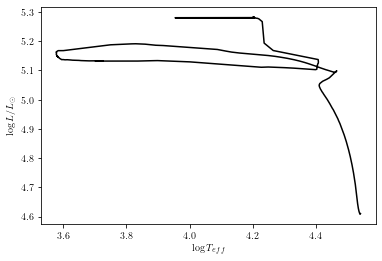

In [55]:
g = pd.read_table('../data/Geneva/M020Z14V4.dat',skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
            index_col='line',delim_whitespace=True)
    
plt.plot(g['lg(Teff)'],g['lg(L)'],c='k',ls=ls)

plt.gca().set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$')#,ylim=(4.0,5.6),xlim=(4.1,3.5))

In [149]:
# FYPS are
# 1. Variable by van Genderen 06. Paper I
# 2. Nothing, Paper I
# 3. Nothing, Paper I
# 4. Misc. variable in Ulaczyk (2013)
# 5. Nothing

fyps.to_csv('fyps.csv',index=False)
fyps[['CommonName','TIC ID','RA','Dec','teff','lum']]

CommonName     TIC ID         RA        Dec   teff    lum
39  HD 269953  404850274  85.050696 -69.668015  3.692  5.437
40  HD 269110   40404470  77.294202 -69.603390  3.750  5.251
41  HD 268687   29984014  72.732736 -69.431251  3.784  5.169
42  HD 269840  277108449  84.042007 -68.928129  3.791  5.335
43  HD 269902  277300045  84.539929 -69.105921  3.793  5.352

In [139]:
#alpha cygnis are identified as:
# 1. Put forth as a candidate Alpha Cyg variable by Balona (2019)
# 2. Nothing
# 3. Ellipsoidal/rotational modulation by Pedersen, eclipsing binary by Balona
# 4. Nothing
aceps[['CommonName','lum']]

CommonName    lum
61    HD 269101  4.799
62  SK -69   68  4.611
63    HD 268798  5.071
64    HD 269769  4.714

# Let's see if we take all possible sets of 5 stars from this sample, how many of them have an equal or smaller spread in $\log T_{eff}$ and $\log L$.

In [65]:
import math

def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

print(nCr(len(cool_sgs),5))

18474840.0


In [66]:
def dTL_range(indices):
    this_set = cool_sgs.iloc[list(indices)]
    return this_set['teff'].max() - this_set['teff'].min(),this_set['lum'].max() - this_set['lum'].min()

In [67]:
from itertools import combinations
from multiprocessing import Pool, cpu_count

fyps = cool_sgs[(cool_sgs['teff'] <= 3.8) & (cool_sgs['teff'] >= 3.69) & (cool_sgs['lum'] >= 5.1) & (cool_sgs['lum'] <= 5.5)]
print(len(fyps))

dT_fyps = fyps['teff'].max() - fyps['teff'].min()
dL_fyps = fyps['lum'].max() - fyps['lum'].min()

with Pool(cpu_count() - 1) as p:
    dTLs = list(
        tqdm(
            p.imap(dTL_range, combinations(np.arange(len(cool_sgs),dtype=int),5)), total=nCr(len(cool_sgs),5)
             )    
                )
    
dTLs = np.array(dTLs)

5


0.08727945681802927 0.012043189548596903 0.0007209805335255948


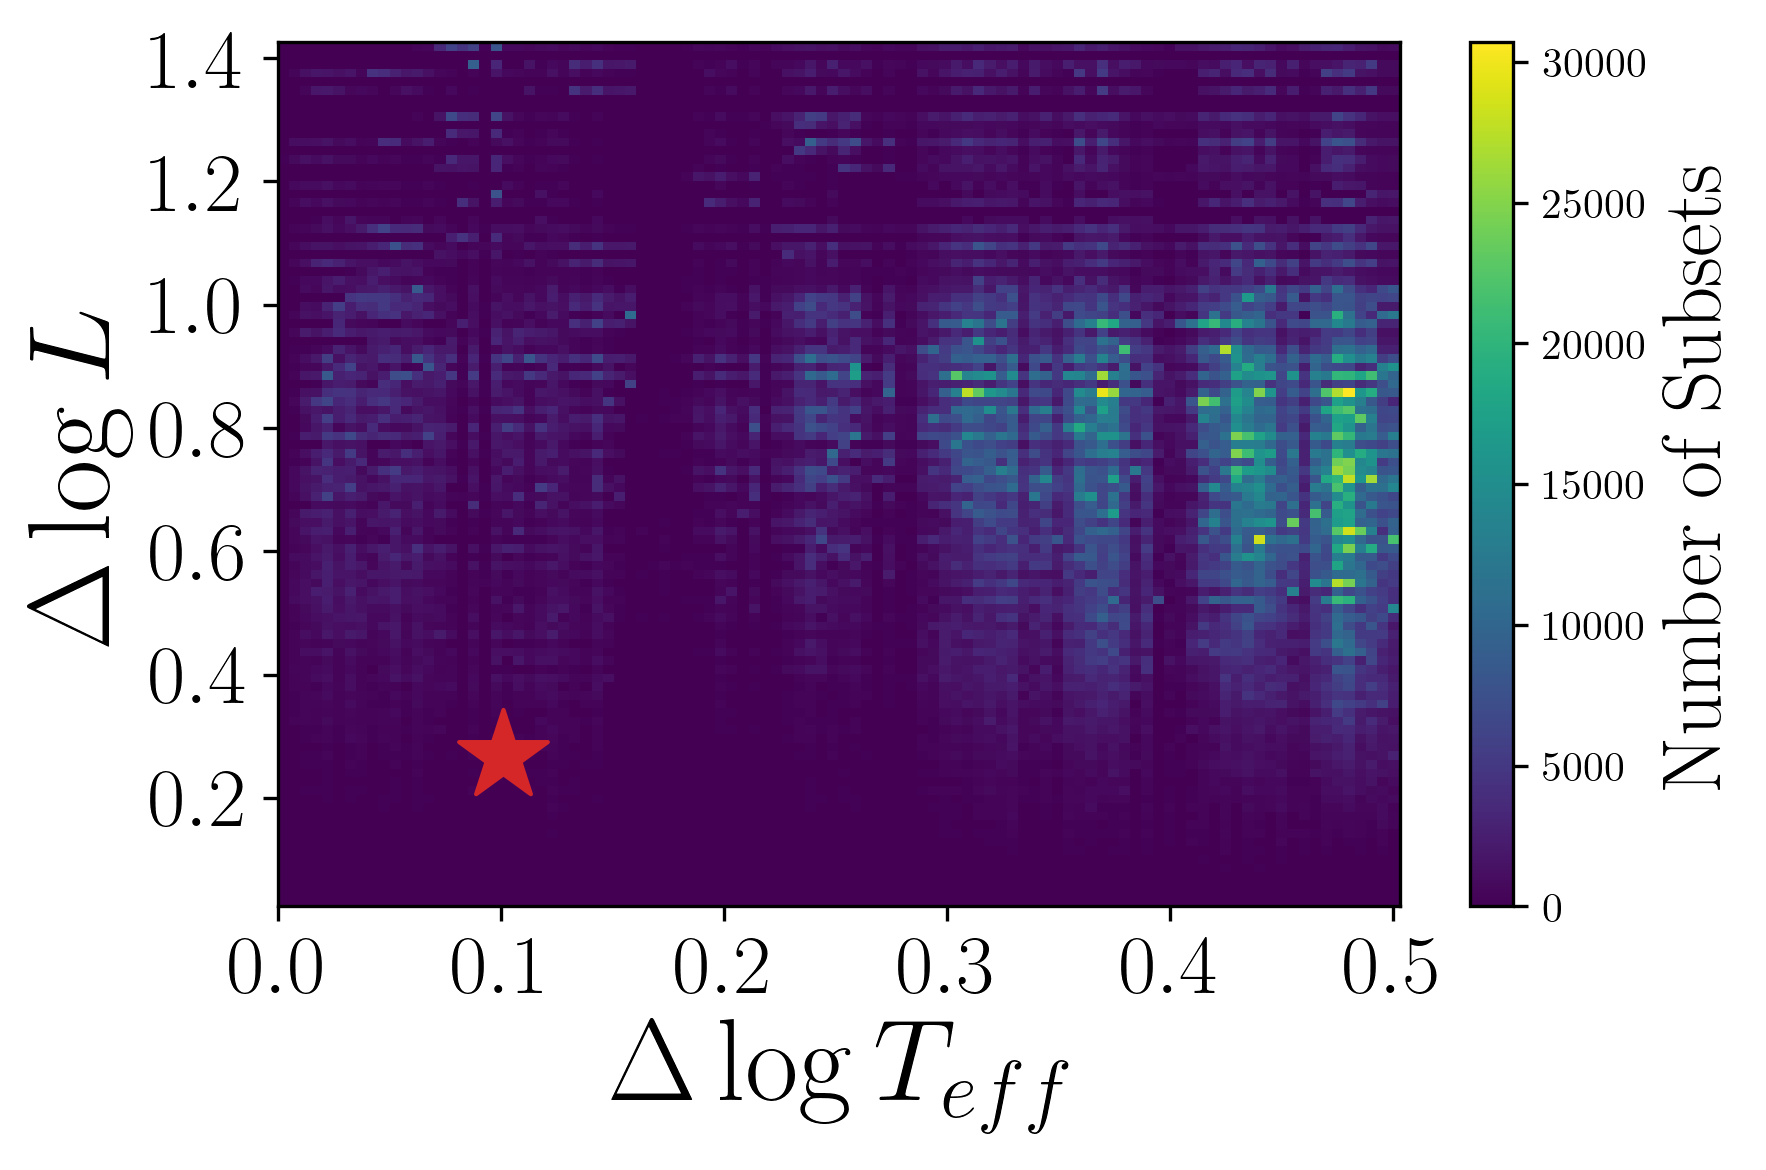

In [68]:
fig = plt.figure(dpi=300)
plt.hist2d(dTLs[:,0],dTLs[:,1],bins=100)
cb = plt.colorbar()
cb.set_label(label='Number of Subsets',fontsize='20')
print(len(dTLs[(dTLs[:,0] <= dT_fyps)])/len(dTLs),len(dTLs[(dTLs[:,1] <= dL_fyps)])/len(dTLs),len(dTLs[(dTLs[:,1] <= dL_fyps)&(dTLs[:,0] <= dT_fyps)])/len(dTLs))
plt.scatter(dT_fyps,dL_fyps,c='C3',marker='*',s=500)
plt.xlabel(r'$\Delta\log{T_{eff}}$')
plt.ylabel(r'$\Delta\log{L}$')
ax = plt.gca()
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.tight_layout()
plt.savefig('../plots/clustering_simulation.pdf')